# Boat detection  with Yolo 9: Pre-training

In this exercise, we explore how to use a pre-trained Yolo 9 model to detect ships from SAR imagery. This is an example of a object detection task in computer vision. Yolo series of model is well known in the field and widely used in industry and research. As its name suggest it is the 9 version of Yolo which stands for You Only Look Once.

Yolo 9 has been trained on COCO benchmark dataset and we trained using the pre-trained weight. The goal is to familiarize ourselves with the process of pre-training with a new dataset.

# Data

We used a SAR dataset from Roboflow. It contains 2000x images of boats labeled with bounding boxes for each boat in a image. This is an ideal dataset to learn about about object detection and fine tuning Yolo 9.

# Model Yolo 9

Yolov9 is the 9th iteration of the Yolo model. First model was published in 2015 by Redmon. Yolo

## Interesting links:

evolution of yolo:

https://www.mdpi.com/2075-1702/11/7/677


Geotiff annotation:
Use this one:
Use this one: https://space.elspina.tech/how-to-annotate-bounding-boxes-with-the-geospatial-data-3dbc7d503f61

https://github.com/satellite-image-deep-learning/annotation

https://medium.com/@iamrizwan077/train-yolov9-on-custom-dataset-7aa41e70cbe3

https://github.com/pylabel-project/pylabel
https://github.com/devrimcavusoglu/pybboxes
https://roboflow.com/formats/yolov9-pytorch-txt
https://docs.ultralytics.com/models/yolov9/#how-can-i-train-a-yolov9-model-using-python-and-cli

https://learnopencv.com/yolov9-advancing-the-yolo-legacy/

Training yolo9 with SAR1 ship

https://medium.com/@ksscs1909/charting-the-course-yolov9-based-sar-ship-detection-explained-a5a57c0d1a84


https://blog.roboflow.com/train-yolov9-model/






# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

First let's install GDAL binaries.

In [ ]:
#install gdal to run from the terminal
!sudo add-apt-repository ppa:ubuntugis/ppa -y
!sudo apt-get update
!sudo apt-get install gdal-bin
!gdalinfo --version

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/ jammy main'
Description:
Official stable UbuntuGIS packages.


More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ppa.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4

Install other geospatial related libraries

In [ ]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 93.2 MB/s eta 0:00:00


In [ ]:
#set up libararies for GIS/Geospatial
try: # try the following b+lock of code
  import geopandas as gpd
except: # if the try block throws an error, run the following
  !pip install geopandas # install geopandas
  import geopandas as gpd

try:
  import contextily as ctx # import
  import rasterio
except:
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  !pip install rasterio
import fiona # library for reading/writing GIS files, comes w/ geopandas
from shapely.geometry import Point, LineString, Polygon

!pip install pyproj
# Mapping,vector related imports
import geopandas as gpd
#import descartes #nessary for plotting in geopandas
from cartopy import crs as ccrs
from pyproj import Proj
#from osgeo import osr
from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon

from collections import OrderedDict
#rasterio imports, gdal and imagery utility
import rasterio
from rasterio.windows import Window
from osgeo import gdal
from rasterio import plot
from PIL import Image

#xarray and rio
!pip install rioxarray
!pip install mapclassify
!pip install earthpy

import mapclassify
import folium
import pyproj as proj
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
from folium.utilities import none_max
import folium
from pyproj import Transformer

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libproj-dev is already the newest version (9.1.1-1~jammy0).
libproj-dev set to manually installed.
proj-data is already the newest version (9.1.1-1~jammy0).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 197 kB of archives.
After this operation, 504 kB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 proj-bin amd64 9.1.1-1~jammy0 [197 kB]
Fetched 197 kB in 2s (82.4 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 126021 files and directories currently installed.)
Preparing to unpack .../proj-bin_9.1.1-1~jammy0_amd64.deb ...
Unpacking proj-bin (9.1.1-1~jammy0) ...
Setting up proj-bin (9.1.1-1~jammy0) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists... Do

General purpose libraries and packages

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import subprocess
import pandas as pd
import os, glob
import zipfile

from pathlib import Path

sns.set_style('darkgrid')
#pd.set_option('display.max_colwidth', None)
!apt install unzip
import urllib
import re
import math
from datetime import datetime
from copy import deepcopy
from numpy.core.multiarray import datetime_as_string
import os
import numpy.ma as ma

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [ ]:
#Used in defining functions
from typing import List, Tuple, Dict, Any
from pandas.core.arrays import boolean

In [ ]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (45.8 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 126047 files and directories currently instal

Now let's intall libraries related to Yolo 9 model from ultralytics

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!nvidia-smi -L

Setting up environmental variables. We are using dotenv python package to set the environmental variables.


# Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the 13 functions used:

In [ ]:
def create_dir_and_check_existence(path: str) -> str:
  '''
  Create a new directory

  :param path: path to the directory
  :return: path to the directory
  '''

  try:
    os.makedirs(path)
  except:
    print ("directory already exists")
  return path



In [ ]:

def bbox_to_poly(bbox: list) -> Polygon:

  '''
  Convert bounding box list into a polygon. With input list xmin,ymin,xmax,ymax.

  :param bbox list: list of coordinates represending a bouding.
  :return: Shapely polygon

  '''

  long0 = bbox[0]
  lat0 = bbox[1]
  long1=bbox[2]
  lat1=bbox[3]

  poly = Polygon([[long0, lat0],
                        [long1,lat0],
                        [long1,lat1],
                        [long0, lat1]])

  return poly

In [ ]:
#remove +init epsg because depecated (October 2024)
def polygon_from_centroid(x_centroid,y_centroid,size,EPSG_val=4326)-> gpd.GeoDataFrame:

  '''

  Generate a square polygon from center point with a given size and EPSG code
  Return a GeoDataFrame

  :param x_centroid float32: x center of square polygon being created
  :param y_centroid float32: y center of square polygon being created
  :param size float32: length of square polygon
  :param EPSG_val int: EPSG code defining the coordinate system
  :return geopandas geodataframe

  '''

  xmin = x_centroid - size/2
  xmax = x_centroid + size/2
  ymin = y_centroid - size/2
  ymax = y_centroid + size/2

  bbox_list = [xmin,ymin,xmax,ymax]
  bbox_poly = bbox_to_poly(bbox_list)

  bbox_poly_gdf = gpd.GeoDataFrame(pd.DataFrame(['p1'], columns = ['geom']),
         crs = f'EPSG:{EPSG_val}',
         geometry = [bbox_poly])
  bbox_poly_gdf.to_file('bbox_poly.shp')

  return bbox_poly_gdf

In [ ]:
def generate_files_data_df(in_path,image_extension='.jpg',label_extension='.txt'):
    """
    Generate data frame for the input files used in the Yolo training

    Input Arguments:

    in_path: parent directory path to the data files

    Return Outputs:

    files_df: pandas dataframe contains the image and label files for the given path

    """

    fileglob = f"*{image_extension}"
    img_path_file = os.path.join(in_path,'images',fileglob) #raw raster
    fileglob = "*.txt" #labels
    fieleglob = f"*{label_extension}"
    labels_path_file = os.path.join(in_path,'labels',fileglob) #raw raster

    img_files = glob.glob(img_path_file,recursive=False)
    labels_files = glob.glob(labels_path_file,recursive=False)

    img_df = pd.DataFrame({'img':img_files})
    labels_df = pd.DataFrame({'labels':labels_files})

    img_df['id_img'] = img_df['img'].apply(lambda x: os.path.basename(x).replace(image_extension,""))
    labels_df['id_img'] = labels_df['labels'].apply(lambda x: os.path.basename(x).replace('.txt',""))

    files_df = (img_df.merge(labels_df,
                                      left_on='id_img',
                                      right_on='id_img',
                                      how='inner')
        )
    files_df['type']= files_df['img'].apply(lambda x: os.path.basename(os.path.dirname(os.path.dirname(x)))) #make it more elegant later

    return files_df,labels_df


# Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [ ]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/'
#ARG 2
out_dir = "/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARG 4
out_suffix = "yolo9_training_exploration_20250131" #output suffix for the files and ouptut folder
#ARG 5
NA_value = -32768.0 # currently not used: Nan value
#ARG 6
random_seed=105 # set seed for reproducibility of results


In [ ]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


directory already exists


In [ ]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131


#0.About Yolo 9 model


Yolov9 novelty resides in the way it attempts retain the maximum information as the model is learning through the layers. In order to combat the vanishing gradient and information detoriation, it uses two new principles:

Programmable Gradient Information (PGI)

Generalized Efficient Layer Aggregation Network (GELAN)

https://docs.ultralytics.com/models/yolov9/#information-bottleneck-principle


X = v_zeta(r_psi(X))


results = model(frame, conf=0.5)
To get the confidence and class values from the prediction results (in case you are working with the detection task model which predicts boxes):

results[0].boxes.conf
results[0].boxes.cls


Outputs predictions from yolo see the link below
.
https://docs.ultralytics.com/modes/predict/#image-and-video-formats

https://stackoverflow.com/questions/77100651/how-to-find-confidence-yolo-v8


Links:


#1.Yolo 9: first training  and exploration

Let's take a look at yolo9. We must first import the relevant libraries.


In [ ]:
import ultralytics
from IPython.display import Image
ultralytics.checks()

Ultralytics 8.3.71 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (AMD EPYC 7B12)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 33.2/225.8 GB disk)


Yolo 9 comes in different flavors can perform different computer vision. Here is quick summary.

Model size: there are 4 different model size with different number of parameters and performance. Smaller models can be more easily run on edge devices (e.g. phones) where resources are more limited but at the cost of a lower accuracy.

CV tasks: Yolo9 can perform many different computer vision tasks including:
- classificiation
- object detection
- instance segmentation
- pose


Detection (COCO)
Segmentation (COCO)
Model	size
(pixels)	mAPval
50-95	mAPval
50	params
(M)	FLOPs
(B)
YOLOv9t	640	38.3	53.1	2.0	7.7
YOLOv9s	640	46.8	63.4	7.2	26.7
YOLOv9m	640	51.4	68.1	20.1	76.8
YOLOv9c	640	53.0	70.2	25.5	102.8
YOLOv9e	640	55.6	72.8	58.1	192.5



We will the weights from small Yolo9c model when instantiating the model.

In [ ]:
from ultralytics import YOLO

# Build a YOLOv9c model from pretrained weights and train
model = YOLO("yolov9c.pt")
model.info()


YOLOv9c summary: 618 layers, 25,590,912 parameters, 0 gradients, 104.0 GFLOPs


(618, 25590912, 0, 104.02268160000003)

In [ ]:
#model = YOLO("yolo11n.pt")
results = model.train(data="coco8.yaml", epochs=3, imgsz=640,project=out_dir,name='train_exploration')

Ultralytics 8.3.71 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=coco8.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131, name=train_exploration5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

100%|██████████| 755k/755k [00:00<00:00, 3.29MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512

train: Scanning /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


Plotting labels to /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_exploration5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_exploration5
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.194      2.533      1.738         19        640: 100%|██████████| 1/1 [00:13<00:00, 13.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]

                   all          4         17      0.888      0.917      0.972      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G     0.8411      1.629      1.245         34        640: 100%|██████████| 1/1 [00:08<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]

                   all          4         17      0.888      0.919      0.972      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G     0.7817      1.343      1.131         29        640: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

                   all          4         17      0.887      0.918      0.972      0.748



3 epochs completed in 0.013 hours.
Optimizer stripped from /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_exploration5/weights/last.pt, 51.7MB
Optimizer stripped from /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_exploration5/weights/best.pt, 51.7MB

Validating /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_exploration5/weights/best.pt...
Ultralytics 8.3.71 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (AMD EPYC 7B12)
YOLOv9c summary (fused): 384 layers, 25,380,928 parameters, 0 gradients, 102.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


                   all          4         17      0.887      0.918      0.972      0.748
                person          3         10      0.962        0.6      0.859      0.442
                   dog          1          1      0.757          1      0.995      0.895
                 horse          1          2      0.824          1      0.995      0.678
              elephant          1          2          1       0.91      0.995      0.582
              umbrella          1          1          1          1      0.995      0.995
          potted plant          1          1      0.781          1      0.995      0.895
Speed: 0.4ms preprocess, 597.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_exploration5


After training, we can see two folders:
- datasets: contains the Coco 8 datasets used during the training
- runs: contains the results of the training.

We can also see the file:
- yolov9c.pt: this file contains the weights and yolo 9 model in pytorch format.

Let's inspect in more details each folder. We start with the dataset folder and move to the runs folder next.

In [ ]:
!ls -ltr

total 50756
-rw------- 1 root root 51794840 Jan 31 17:13 yolov9c.pt
drwx------ 3 root root     4096 Jan 31 17:13 datasets
drwx------ 2 root root     4096 Jan 31 17:19 train_exploration
drwx------ 2 root root     4096 Jan 31 17:25 train_exploration2
-rw------- 1 root root   137419 Jan 31 17:25 bus.jpg
drwx------ 2 root root     4096 Feb  1 03:05 train_exploration3
drwx------ 2 root root     4096 Feb  1 03:06 train_exploration32
drwx------ 2 root root     4096 Feb  1 04:00 SAR_ship
drwx------ 2 root root     4096 Feb  5 04:16 train_exploration4
drwx------ 2 root root     4096 Feb  5 04:18 train_exploration42
drwx------ 2 root root     4096 Feb  5 04:32 train_SAR_sdp1
drwx------ 3 root root     4096 Feb  5 13:54 train_exploration5


#2.Datasets used in YOLO

The datasets are used to trained Yolo9 model. They are stored in the dataset folder. When we set the argument dataset to 'coco8' during the training process, the coco 8 dataset was downloaded a placed in the dataset folder under the new 'coco8' directory. Additional datasets can be added in this folder.

In [ ]:
!ls -ltr datasets/coco8/

total 44
-rw------- 1 root root 35126 Jan 31 17:13 LICENSE
drwx------ 4 root root  4096 Jan 31 17:13 images
-rw------- 1 root root   684 Jan 31 17:13 README.md
drwx------ 4 root root  4096 Jan 31 17:13 labels


We can get more information on coco8 by directly reading the markdown readme file. It states that coco8 is simplified version of the coco dataset.

In [ ]:
!cat datasets/coco8/README.md

# Ultralytics COCO8 Dataset

Ultralytics COCO8 is a small, but versatile object detection dataset composed of the first 8 images of the COCO train
2017 set, 4 for training and 4 for validation. This dataset is ideal for testing and debugging object detection models,
or for experimenting with new detection approaches. With 8 images, it is small enough to be easily manageable, yet
diverse enough to test training pipelines for errors and act as a sanity check before training larger datasets.

This dataset is intended for use with Ultralytics YOLOv8.

Docs: https://docs.ultralytics.com
Community: https://community.ultralytics.com
GitHub: https://github.com/ultralytics/ultralytics

Datasets used by Yolo follow specific directory structure:

- labels: contain the labeling txt file with the bounding boxes location for each image. It contains val, train and test folders
- images

For instance the train folder contains 4 text files corresponding to bounding boxes found in the 4 images.

In [ ]:
!tree datasets/coco8/

datasets/coco8/
├── images
│   ├── train
│   │   ├── 000000000009.jpg
│   │   ├── 000000000025.jpg
│   │   ├── 000000000030.jpg
│   │   └── 000000000034.jpg
│   └── val
│       ├── 000000000036.jpg
│       ├── 000000000042.jpg
│       ├── 000000000049.jpg
│       └── 000000000061.jpg
├── labels
│   ├── train
│   │   ├── 000000000009.txt
│   │   ├── 000000000025.txt
│   │   ├── 000000000030.txt
│   │   └── 000000000034.txt
│   ├── train.cache
│   ├── val
│   │   ├── 000000000036.txt
│   │   ├── 000000000042.txt
│   │   ├── 000000000049.txt
│   │   └── 000000000061.txt
│   └── val.cache
├── LICENSE
└── README.md

6 directories, 20 files


Next we use the trained model to predict and explore results of the model.

#3.Exploring training results

Results from the training are stored in the 'detect' folder because we carried out a 'detect' task. The first time a model is trained, a directory called 'train1' is created. Note that for each new iteration of traning a new directory is created.

The train directory has the following structure:

- weights: dir with weights of hte model
- args.yaml: arguments used during the trainig
- accuracy plots: plots of Precision, Recall and F1 scores as well Precision-Recall curves in png format.
- confusion metric figure in png format



In [ ]:
!tree train_exploration

train_exploration
├── args.yaml
├── confusion_matrix_normalized.png
├── confusion_matrix.png
├── F1_curve.png
├── labels_correlogram.jpg
├── labels.jpg
├── P_curve.png
├── PR_curve.png
├── R_curve.png
├── results.csv
├── results.png
├── train_batch0.jpg
├── train_batch1.jpg
├── train_batch2.jpg
├── val_batch0_labels.jpg
├── val_batch0_pred.jpg
└── weights
    ├── best.pt
    └── last.pt

1 directory, 18 files


Let's take a look at the weights dir. We can see that the last model weights and the best model weights are recorded in a pytorch file 'last.pt' and 'best.pt'.

In [ ]:
!cat train_exploration/args.yaml #this contains all the arguments set for the model

task: detect
mode: train
model: yolov9c.pt
data: coco8.yaml
epochs: 3
time: null
patience: 100
batch: 16
imgsz: 640
save: true
save_period: -1
cache: false
device: null
workers: 0
project: /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131
name: train_exploration
exist_ok: false
pretrained: true
optimizer: auto
verbose: true
seed: 0
deterministic: true
single_cls: false
rect: false
cos_lr: false
close_mosaic: 10
resume: false
amp: true
fraction: 1.0
profile: false
freeze: null
multi_scale: false
overlap_mask: true
mask_ratio: 4
dropout: 0.0
val: true
split: val
save_json: false
save_hybrid: false
conf: null
iou: 0.7
max_det: 300
half: false
dnn: false
plots: true
source: null
vid_stride: 1
stream_buffer: false
visualize: false
augment: false
agnostic_nms: false
classes: null
retina_masks: false
embed: null
show: false
save_frames: false
save_txt: false
save_conf: false
save_crop: false
show_labels:

In [ ]:
!cat train_exploration/results.csv

epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
1,10.0846,1.18796,2.46859,1.73148,0.8833,0.93159,0.97306,0.75999,1.23964,0.62087,1.28942,0,0,0
2,22.4276,0.8282,1.59066,1.23754,0.8706,0.92168,0.97098,0.73441,1.23975,0.61085,1.29297,7.973e-07,7.973e-07,7.973e-07
3,33.8263,0.77731,1.33116,1.1286,0.88884,0.9141,0.971,0.73917,1.24196,0.6066,1.29257,8.092e-07,8.092e-07,8.092e-07


In [ ]:
pd.read_csv("train_exploration/results.csv")

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,10.0846,1.18796,2.46859,1.73148,0.88330,0.93159,0.97306,0.75999,1.23964,0.62087,1.28942,0.000000e+00,0.000000e+00,0.000000e+00
1,2,22.4276,0.82820,1.59066,1.23754,0.87060,0.92168,0.97098,0.73441,1.23975,0.61085,1.29297,7.973000e-07,7.973000e-07,7.973000e-07
2,3,33.8263,0.77731,1.33116,1.12860,0.88884,0.91410,0.97100,0.73917,1.24196,0.60660,1.29257,8.092000e-07,8.092000e-07,8.092000e-07


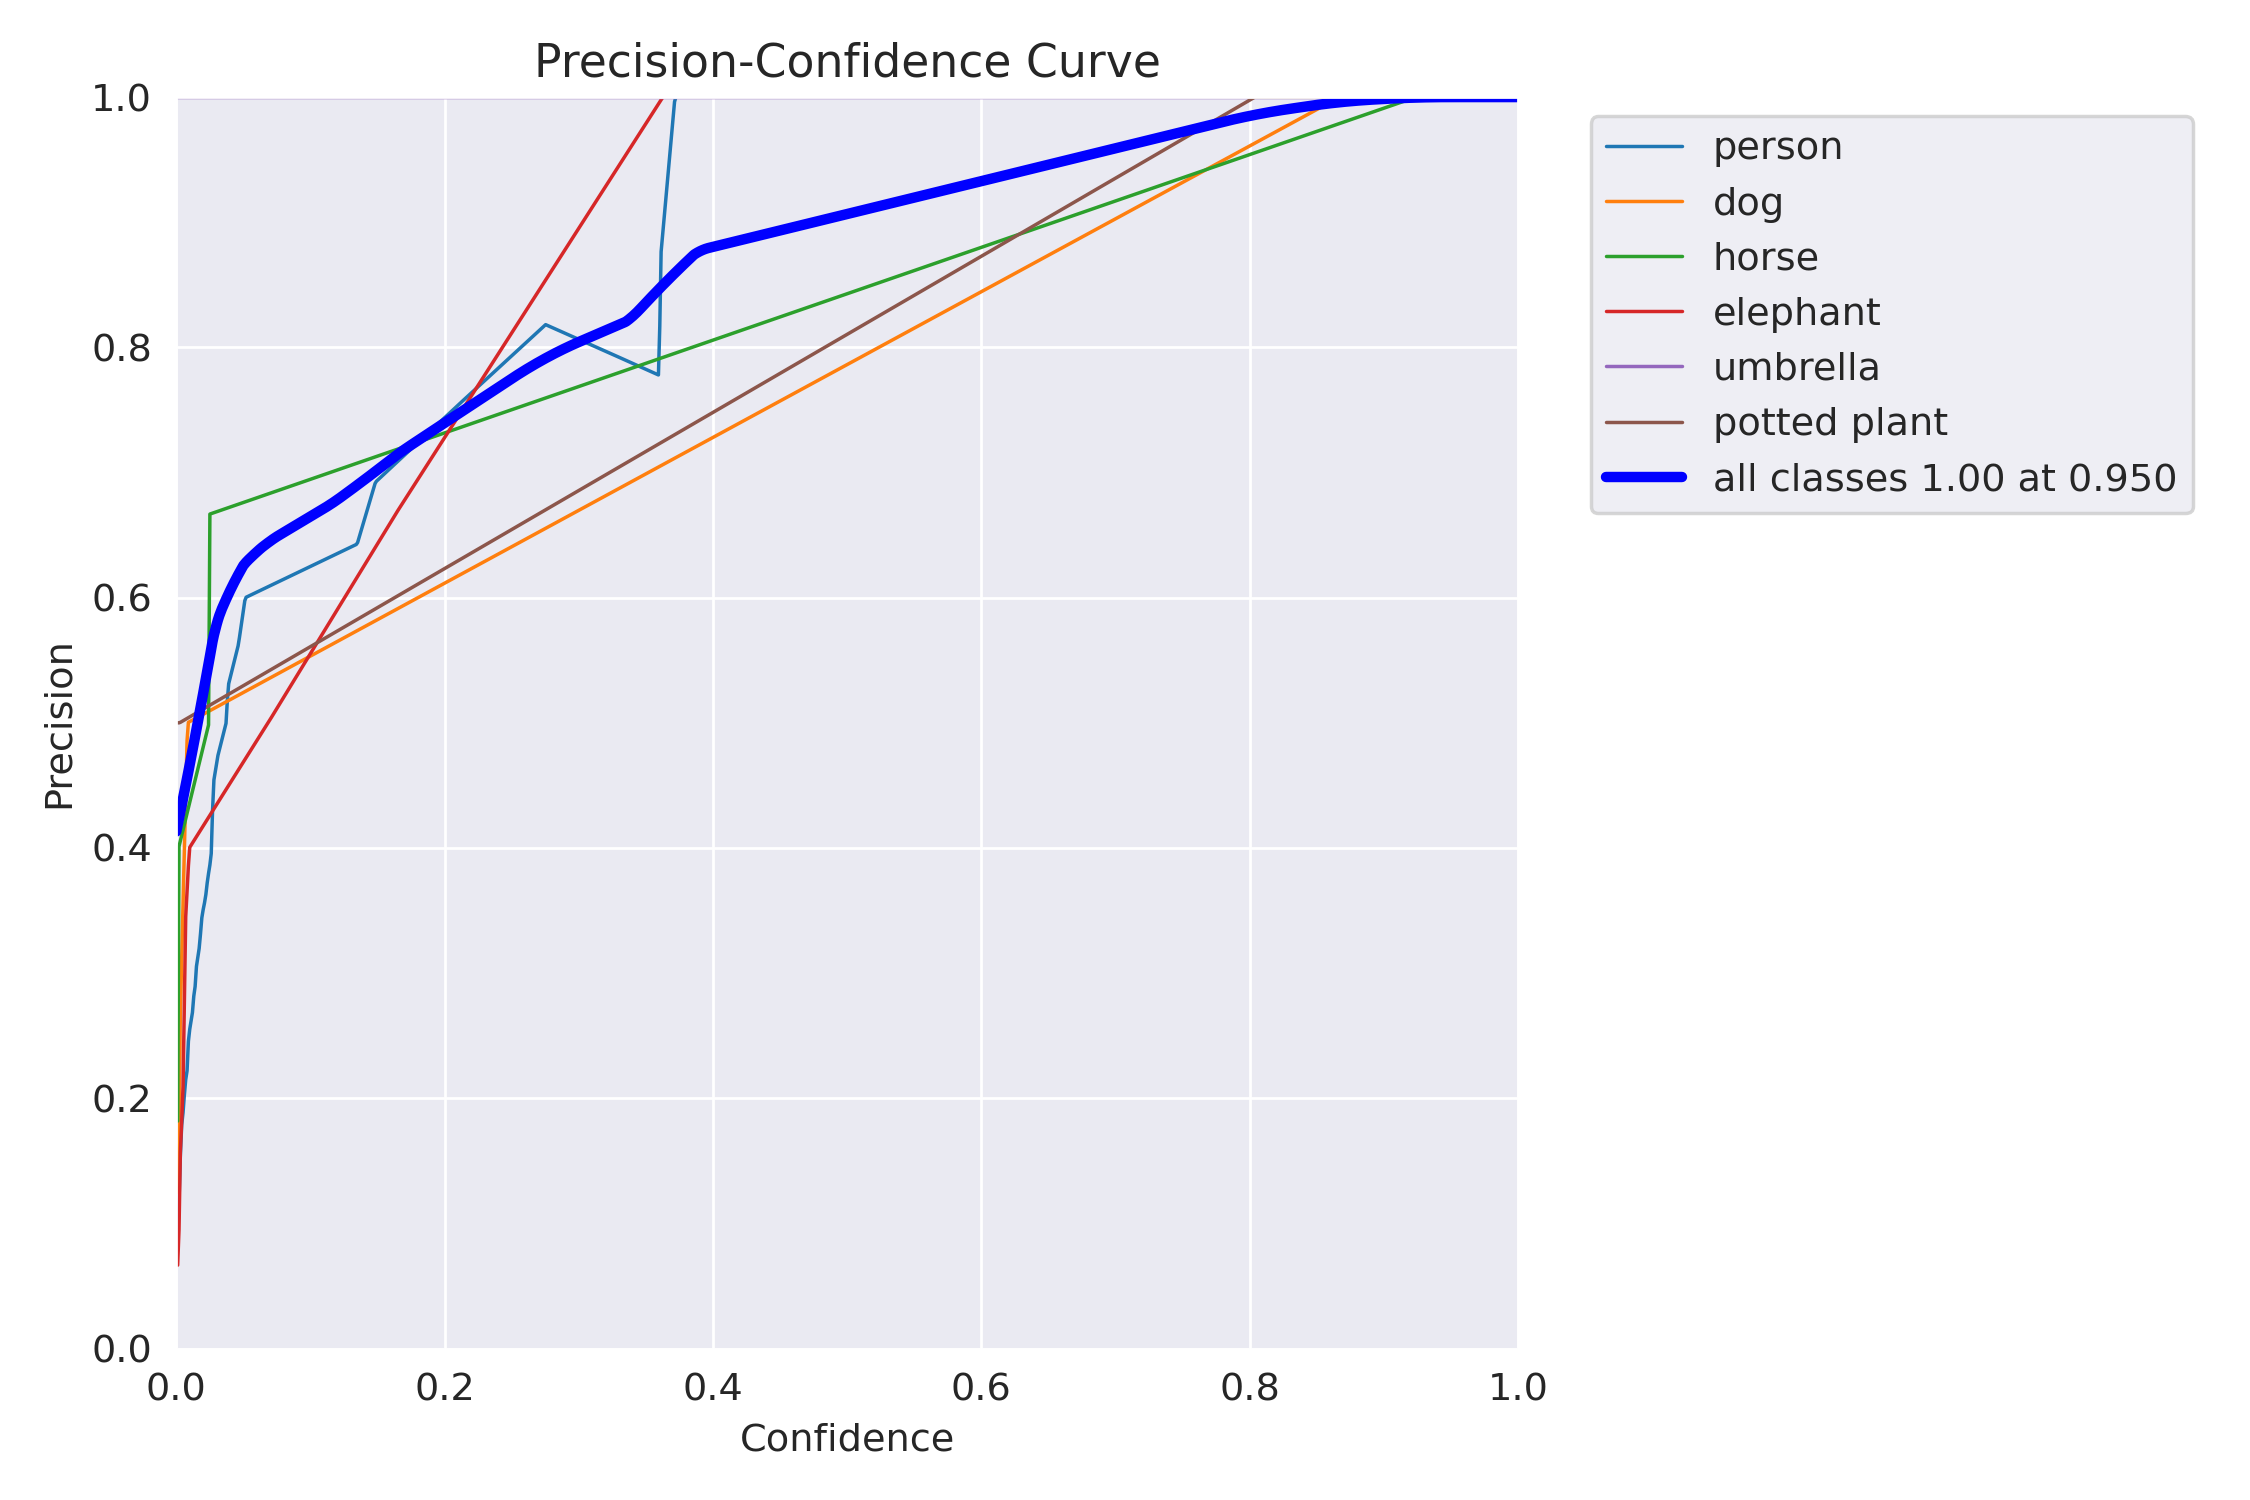

In [ ]:
Image("./train_exploration/P_curve.png", width=600)

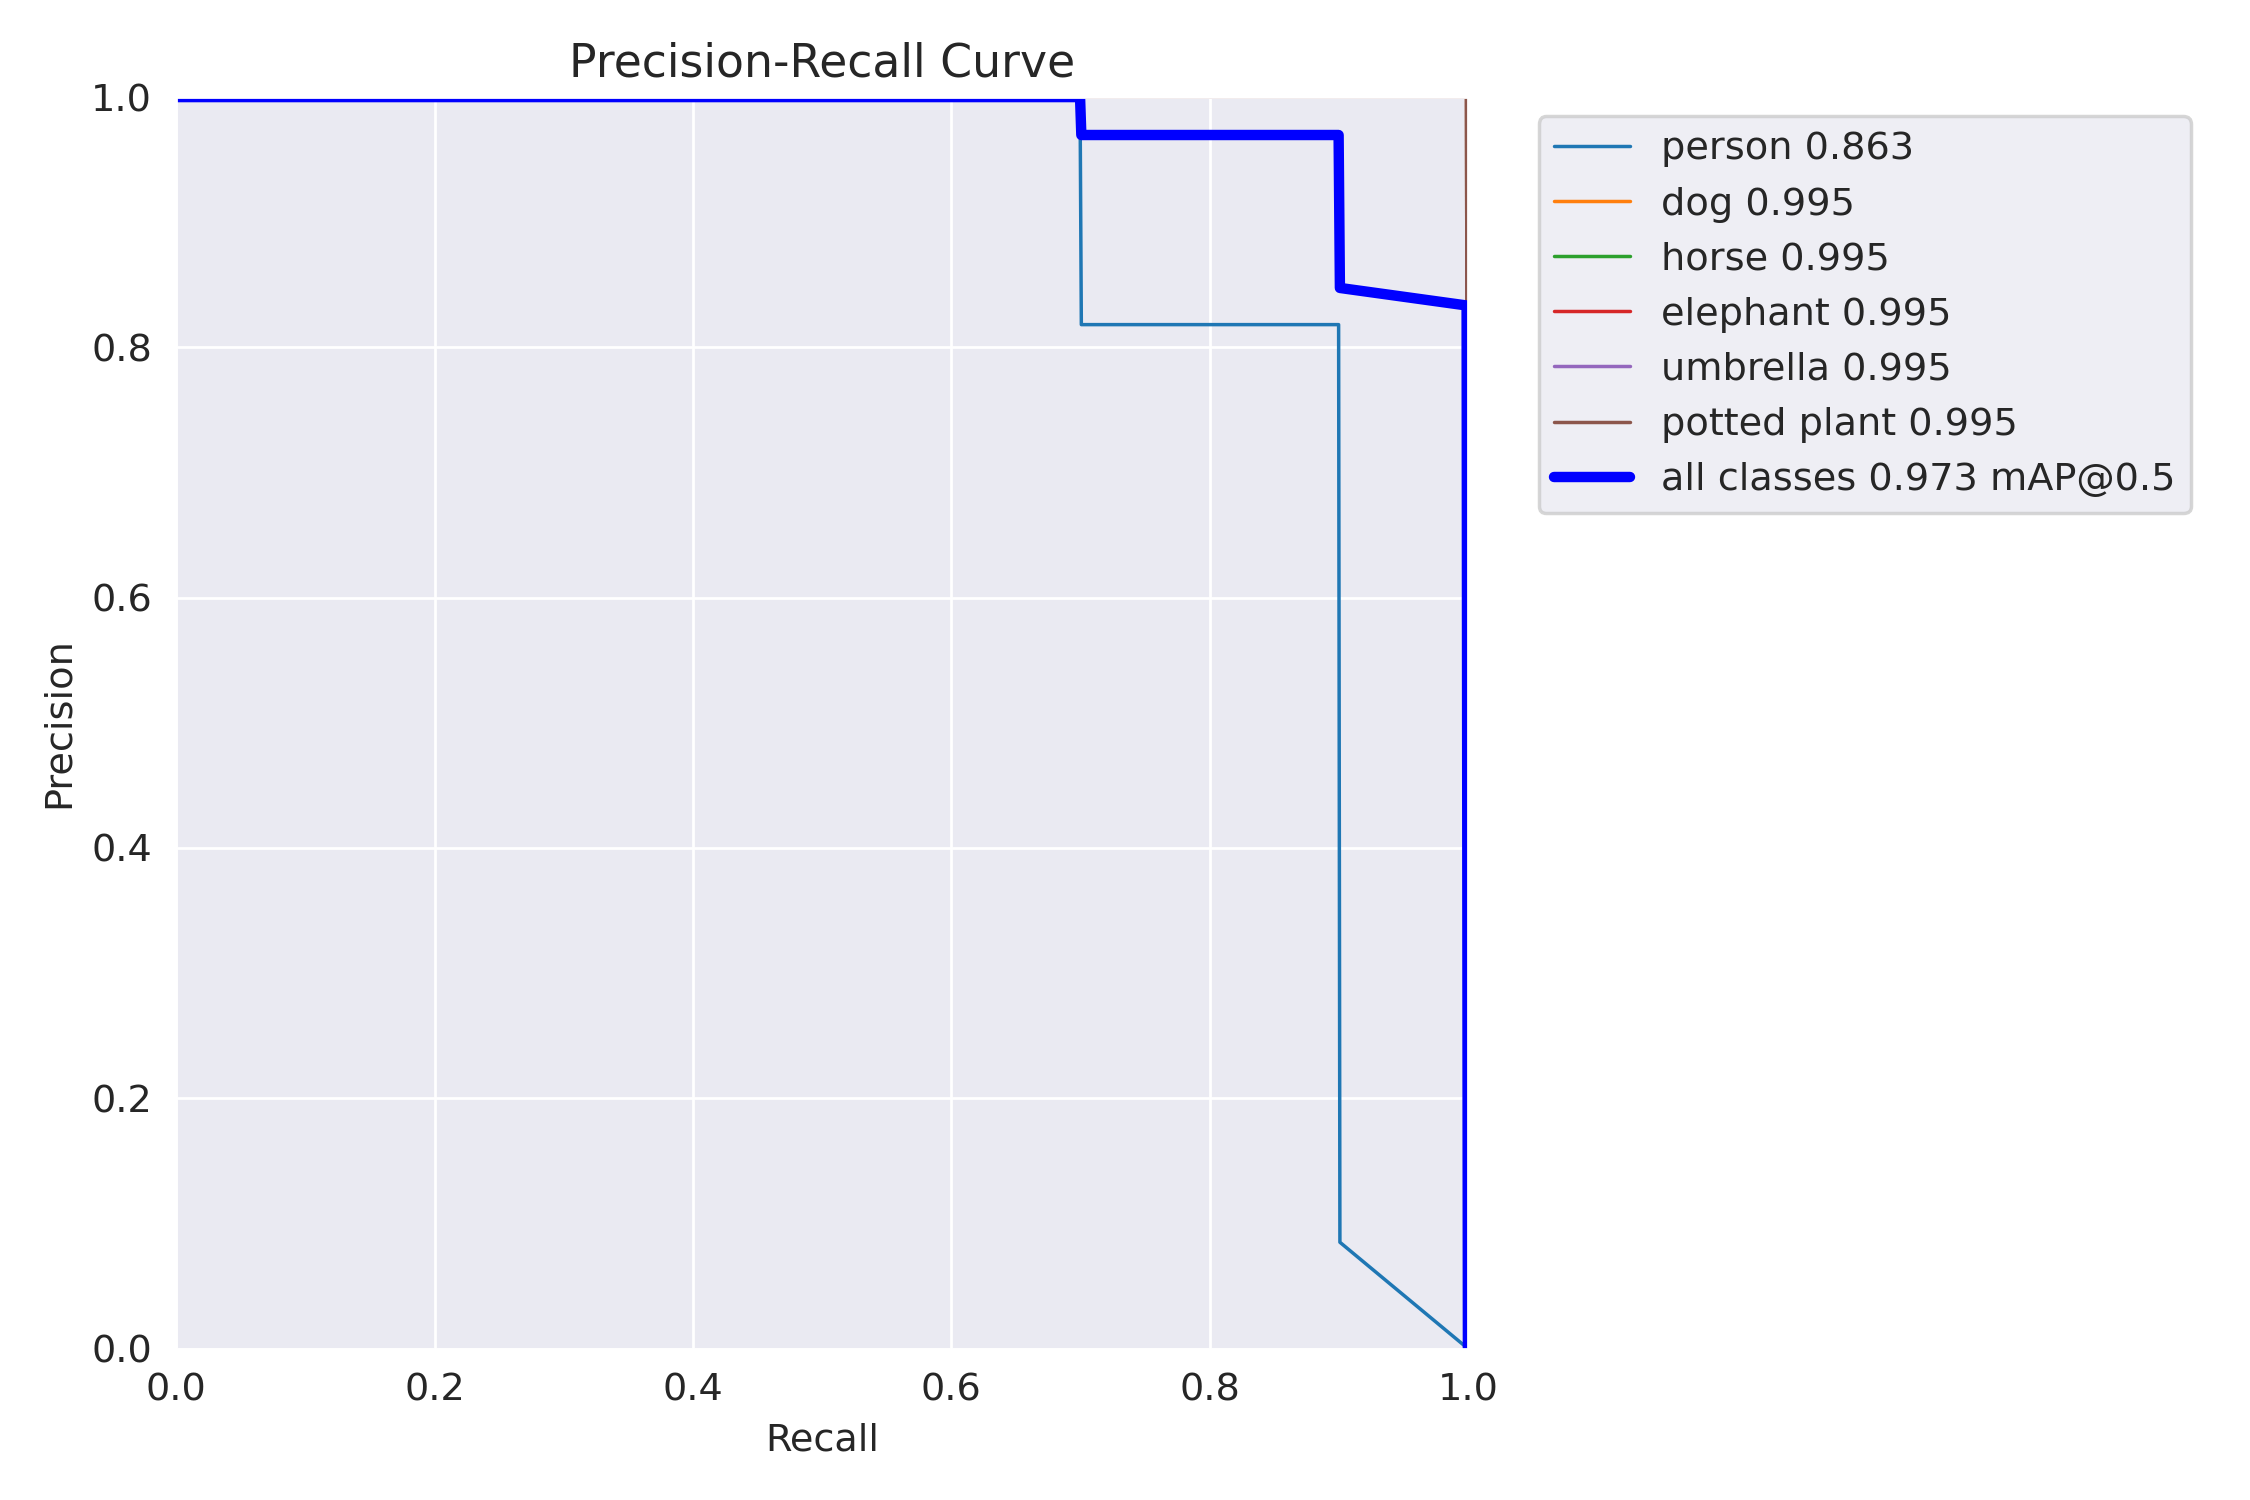

In [ ]:
Image("./train_exploration/PR_curve.png", width=600)

All the plotted information can be recovered in the results object that is the output from the train model. See below:

In [ ]:
print(results.ap_class_index)
print(len(results.box.curves_results))

[ 0 16 17 20 25 58]
4


#4.Prediction/Inference on a trained model

Now that the model has been trained we can make inference/prediction using example images. We will the example image provided in the tutorial called 'bus.jpg'.

We call the predict function and capture the output in results_val. This is a list that contains a lot of useful information that we can be parsed. Each element of the list contains an object of the class results that was designed to store inference/prediction results.

Useful links:

- box_convert: a function made avaible in torchvision library to convert across many box formats: https://pytorch.org/vision/master/generated/torchvision.ops.box_convert.html

- predict usiing yolo models from ultralytics:
https://docs.ultralytics.com/modes/predict/

In [ ]:
#https://ultralytics.com/images/bus.jpg

results_eval = model.predict(source='https://ultralytics.com/images/bus.jpg', save=True)
print(type(results_eval))
print(len(results_eval)) #length 1 because we only passed one image
type(results_eval[0]) #


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/bus.jpg: 640x480 4 persons, 1 bus, 539.2ms
Speed: 2.8ms preprocess, 539.2ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_exploration52
<class 'list'>
1


ultralytics.engine.results.Results

In [ ]:
type(results_eval[0].boxes)

ultralytics.engine.results.Boxes

Let's take a look at the box attributes and find out how to extract and plot the predicted object boxes.

We can see that the 'boxes' class contains a lot of information. We hilight here a few import attributes:

- cls: these are the classes present in the image we fed in the network for prediction. In our case we have 5 objects present in the image.
- conf: this is the confidence level or the probablity of the presence of an object in the box.
- data: this is the

In [ ]:
print(type(results_eval[0].boxes.xyxy))
print((results_eval[0].boxes.xyxy).shape)
results_eval[0].boxes.xyxy[0,:]


<class 'torch.Tensor'>
torch.Size([5, 4])


tensor([ 13.0436, 229.8365, 806.1320, 738.5991])

From the documentation:
https://docs.ultralytics.com/modes/predict/#inference-arguments

https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Boxes

Box coordinates

- xyxy	Property (torch.Tensor)	Return the boxes in xyxy format, this is one of the most common format in Computer Vision for boxes: top left* (x1,y1)and bottom right corners (x2,y2).
- xywh	Property (torch.Tensor)	Return the boxes in xywh format, this correspond to the top left corner and with and height of the box.
- xyxyn	Property (torch.Tensor)	Return the boxes in xyxy format normalized by original image size.
- xywhn	Property (torch.Tensor)	Return the boxes in xywh format normalized by original image size.

Other information:

- conf	Property (torch.Tensor)	Return the confidence values of the boxes.
- cls	Property (torch.Tensor)	Return the class values of the boxes.
- id	Property (torch.Tensor)	Return the track IDs of the boxes (if available).


It is also important to note that for the training fo yolo we need another box format. This will be discussed in more details below.


In [ ]:
print(results_eval[0].boxes.conf) #these are the confidence scores in the pred: obj score*class_score
print(results_eval[0].boxes.cls) #these are the class labels: there are 5 objects: bus, person, person, person, person
print(type(results_eval[0].boxes.cls))
print('Classes in the corresponding image: ',results_eval[0].boxes.cls) #it's number 5
print(results_eval[0].names)
print('class name is :',results_eval[0].names[int(results_eval[0].boxes.cls[0])])

tensor([0.9561, 0.9406, 0.9180, 0.8950, 0.8518])
tensor([5., 0., 0., 0., 0.])
<class 'torch.Tensor'>
Classes in the corresponding image:  tensor([5., 0., 0., 0., 0.])
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'co

Now we can create a plot of a box with its corresponding class label. To add all the boxes, one needs to loop through the boxes in the image.

(1080, 810, 3)


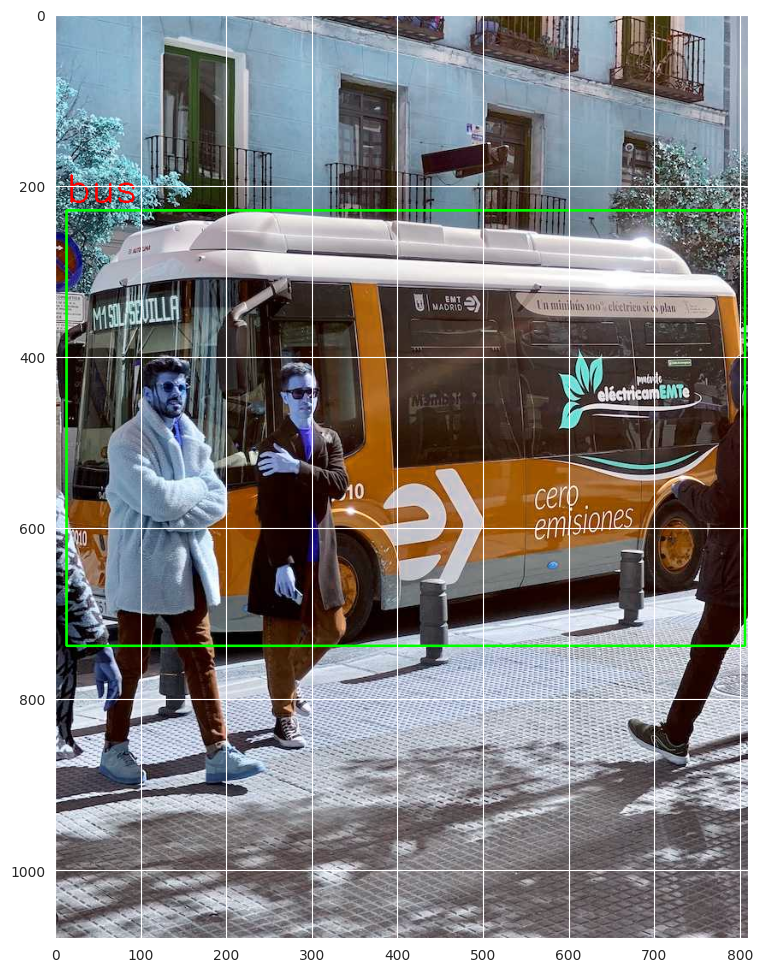

In [ ]:
#bottom left and upper right are used in plotting
import cv2
img = cv2.imread('bus.jpg')
print(img.shape)

text_thickness =4
box = results_eval[0].boxes
top_left = (int(box.xyxy[0][0]), int(box.xyxy[0][1]))
bottom_right = (int(box.xyxy[0][2]), int(box.xyxy[0][3]))
cv2.rectangle(img, top_left, bottom_right, color=(0, 255, 0), thickness=2)

# Font settings
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1.5  # Adjust this value to change the font size
color = (255, 0, 0)  # BGR color
thickness = 2
# Position of text
org = (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10)  # Bottom-left corner of the text
text_val = f"{results_eval[0].names[int(box.cls[0])]}"

# Add text to image
cv2.putText(img,
            text_val,
            org,
            font,
            font_scale,
            color,
            thickness)

fig, ax = plt.subplots(figsize=(14, 12))
ax.imshow(img)


To make things easier let's use a function to plot the boxes and labels for each image predicted given a specific model object.

In [ ]:
#https://medium.com/@Mert.A/how-to-use-yolov9-for-object-detection-93598ad88d7d

#https://docs.ultralytics.com/modes/predict/#inference-arguments

def predict(chosen_model, img, classes=[], conf=0.5):
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf)
    else:
        results = chosen_model.predict(img, conf=conf)

    return results

def predict_and_detect(chosen_model, img, classes=[], conf=0.5, rectangle_thickness=2, text_thickness=1):
    results = predict(chosen_model, img, classes, conf=conf)
    for result in results:
        for box in result.boxes:
            cv2.rectangle(img, (int(box.xyxy[0][0]), int(box.xyxy[0][1])),
                          (int(box.xyxy[0][2]), int(box.xyxy[0][3])), (255, 0, 0), rectangle_thickness)
            cv2.putText(img, f"{result.names[int(box.cls[0])]}",
                        (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10),
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), text_thickness)
    return img, results


In [ ]:
results_eval

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

#5.Getting and preparing SAR dataset from roboflow

We are using the SAR dataset 'sdp1' that was obtained from robotflow. I downloaded the dataset and placed in the 'SAR_SHIHP' folder in the data folder.

The data is dvided in:

- train:
- test:
- valid:

Each folder contains the labels and images with a tree structure similar to what we describe in section 2. The dataset contains a data.yaml file that describes the dataset and is used during training of the model.

Relevant links:

---
- learning about yaml and pyYAML:
https://medium.com/@p4p3rb0y1/python-yaml-tutorial-getting-started-in-a-few-minutes-24b2d51831f3
- https://universe.roboflow.com/sdp1/sar-full/dataset/1
- https://blog.roboflow.com/yolov11-how-to-train-custom-data/
- https://stackoverflow.com/questions/56676448/how-to-change-a-line-in-a-yaml-file


Let's take a look at he yaml file

In [ ]:
import yaml
with open(os.path.join(in_dir,'SAR_ship/data.yaml')) as file:
    try:
        data_yaml = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
data_yaml

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 29,
 'names': ['ship-1',
  'ship-10',
  'ship-11',
  'ship-12',
  'ship-13',
  'ship-14',
  'ship-15',
  'ship-16',
  'ship-17',
  'ship-18',
  'ship-19',
  'ship-2',
  'ship-20',
  'ship-21',
  'ship-22',
  'ship-23',
  'ship-24',
  'ship-25',
  'ship-26',
  'ship-27',
  'ship-28',
  'ship-29',
  'ship-3',
  'ship-4',
  'ship-5',
  'ship-6',
  'ship-7',
  'ship-8',
  'ship-9'],
 'roboflow': {'workspace': 'sdp1',
  'project': 'sar-full',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/sdp1/sar-full/dataset/1'}}

Create a function to list everything

https://stackoverflow.com/questions/64096953/how-to-convert-yolo-format-bounding-box-coordinates-into-opencv-format

plotting from yolo results
https://medium.com/@telega.slawomir.ai/yolo8-basics-plotting-bboxes-e50a8f3e5227

In [ ]:
list_files_df = []
#list_labels_df = []

for data_type in ['train','test','valid']:
    files_type_df,labels_type_df = generate_files_data_df(in_path=os.path.join(in_dir,'SAR_ship',data_type),
                                      image_extension='.jpg',
                                      label_extension='.txt')
    list_files_df.append(files_type_df)
files_df = pd.concat(list_files_df,ignore_index=True)
#df_labels = pd.concat(list_labels_df,ignore_index=True)
#files_df = generate_files_data_df(in_path=os.path.join(in_dir,'SAR_ship','train'),
#                                  file_extension='.jpg')
#files_df
files_df

,img,id_img,labels,type
0,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000982.rf.a5aac0ba7ee1c78922ee7d6721b0fb3a,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,train
1,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000018.rf.a67b76d0a29d708e148e3701749cc254,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,train
2,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000261_jpg.rf.78c8a00aec2be995d58921f98822f44d,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,train
3,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000834.rf.fdcbe57935e243fcbffb2fd625305f76,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,train
4,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000772_jpg.rf.53284c89ebef8427c4c9865fdadb53c3,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,train
...,...,...,...,...
2263,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000314_jpg.rf.527d3c3915f1f4beffced4be1194ba83,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,valid
2264,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000868.rf.5270f9b0f7316d12a3f93e418445b3ad,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,valid
2265,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000233.rf.55579d692f86e0a298eb5a8e0a176bff,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,valid
2266,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000338.rf.55085cd4a5ca9bf5effb27b069393340,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,valid


In [ ]:
files_df['type'].value_counts()

,count
type,
train,1593
valid,450
test,225


### Plotting a ship with box

/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels/000982.rf.a5aac0ba7ee1c78922ee7d6721b0fb3a.txt
/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/images/000982.rf.a5aac0ba7ee1c78922ee7d6721b0fb3a.jpg
<class 'numpy.ndarray'>
(416, 416, 3)
<class 'pandas.core.frame.DataFrame'>
   class  x_center  y_center     width    height
0      0  0.457933  0.472356  0.109375  0.134615
(416, 416, 3)


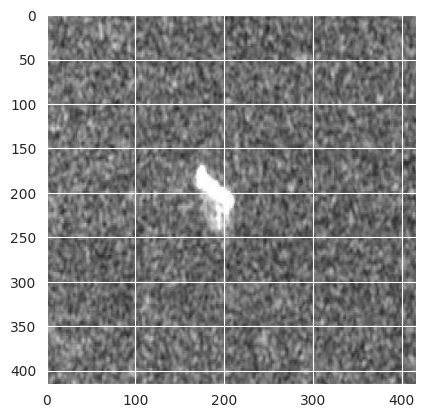

In [ ]:
print(files_df.loc[0,'labels'])
print(files_df.loc[0,'img'])
import cv2
img_sar = cv2.imread(files_df.loc[0,'img'])
print(type(img_sar))
print(img_sar.shape)
label_sar = pd.read_csv(files_df.loc[0,'labels'],sep=" ",header=None,
                        names= ['class','x_center','y_center','width','height'])
print(type(label_sar))
print(label_sar)
print(img_sar.shape)
img_width = img_sar.shape[1]
img_height = img_sar.shape[0]
plt.imshow(img_sar)

\
Also note that the image has 3 channels (remote sensing bands) but these are all equal because it is a copy of band 1.

In [ ]:
print((img_sar[:,:,0] == img_sar[:,:,1]).all())
(img_sar[:,:,0] == img_sar[:,:,2]).all()

True


True

In [ ]:
label_sar['img_width'] = img_width
label_sar['img_height'] = img_height
label_sar

,class,x_center,y_center,width,height,img_width,img_height
0,0,0.457933,0.472356,0.109375,0.134615,416,416


In [ ]:
x_center_box = label_sar.loc[0,'x_center']*label_sar.loc[0,'img_width']
y_center_box = label_sar.loc[0,'y_center']*label_sar.loc[0,'img_height']
width_box = label_sar.loc[0,'width']*label_sar.loc[0,'img_width']
height_box = label_sar.loc[0,'height']*label_sar.loc[0,'img_height']
minx = x_center_box - width_box/2
miny = y_center_box - height_box/2
maxx = x_center_box + width_box/2
maxy = y_center_box + height_box/2
width_val = label_sar.loc[0,'width'] #useful to know size of the box in pixels?
height_val = label_sar.loc[0,'height']
print(minx)
print(maxx)
print(miny)
print(maxy)

167.75
213.25
168.5
224.5


#
https://roboflow.com/use-opencv/draw-a-rectangle-with-cv2-rectangle

The cv2.rectangle method requires the x0, y0 coordinates (top left) and x1, y1 coordinates (bottom right) of the box you want to draw.



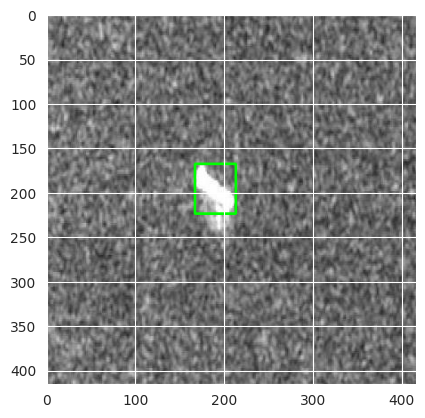

In [ ]:
#bottom left and upper right are used in plotting
top_left = (int(minx), int(miny))
bottom_right = (int(maxx), int(maxy))
cv2.rectangle(img_sar, top_left, bottom_right, color=(0, 255, 0), thickness=2)
plt.imshow(img_sar)

## Examining number of classes and number of boxes

We saw in the yaml file that we have 29 classes. This does not seem to make sense since this dataset is only focused on ship. To gain a better understanding of the dataset let's compute the number of instances of classes and the number of boxes per images.

In [ ]:
in_path = os.path.join(in_dir,'SAR_ship','train','labels','*.txt')
list_files = glob.glob(in_path)
# Loop through each file and append to the combined dataframe
# Create an empty dataframe

list_df = []
for file in list_files:
    df = pd.read_csv(file,header=None,sep=' ')
    df.columns = ['class','x_center','y_center','width','height']
    df['file']= file
    list_df.append(df)
# Print the combined dataframe
df_classes = pd.concat(list_df, axis=0,ignore_index=True)
df_classes['id_img'] = df_classes['file'].apply(lambda x: os.path.basename(x).replace('.txt',""))
df_classes

,class,x_center,y_center,width,height,file,id_img
0,0,0.682692,0.205529,0.051683,0.117788,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000337.rf.facfae8303d22efb2a9511512b4be301
1,11,0.544471,0.460337,0.027644,0.080529,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000337.rf.facfae8303d22efb2a9511512b4be301
2,22,0.480769,0.931490,0.036058,0.092548,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000337.rf.facfae8303d22efb2a9511512b4be301
3,0,0.305288,0.251202,0.048077,0.042067,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,001109_jpg.rf.9298cedd1e0ffbf6443df4a0411f8b20
4,11,0.282452,0.401442,0.046875,0.045673,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,001109_jpg.rf.9298cedd1e0ffbf6443df4a0411f8b20
...,...,...,...,...,...,...,...
3439,0,0.582933,0.301683,0.115385,0.305288,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000001_jpg.rf.5c46fdd2afb9c5ef32c647cae6c2c521
3440,0,0.555288,0.608173,0.334135,0.092548,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000021_jpg.rf.e677584e035938b755c078993722460a
3441,0,0.243990,0.353365,0.055288,0.164663,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000701_jpg.rf.4ce0b0f9711be2c33a2dd701a80f89d7
3442,0,0.120192,0.743990,0.026442,0.098558,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000648.rf.36073d60fc265be3f5578618640cbdf3


We have 3444 boxes rows for training dataset and 1593 images. So there are in many case multiple object per images. Let's dive in a bit more and compute the number.

In [ ]:
print(df_classes['file'].nunique()) #number of images and text files containing the box coordinates
df_classes['class'].value_counts()

1593


,count
class,
0,1593
11,625
22,360
23,239
24,189
25,119
26,91
27,63
28,57


All images contain class 0, class 1 is found in 39 images. If we now counts the number of time files appear we can see that the class correspond to the number of ships in an image. Each ship was labeled individually with a class number and the maximum number of ships in a image is 29. See below.

In [ ]:
df_classes['file'].value_counts()

,count
file,
/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels/001112.rf.5af70283c586b5b7f8527007f754d956.txt,29
/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels/001093_jpg.rf.80e9c372a43e714a39618158b3967e0a.txt,20
/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels/001093.rf.6f767f77ad05e2fd8f32ea798fb7d120.txt,20
/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels/001149.rf.f51bb5d3c85aa5f1293916942dd18f78.txt,17
/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels/001091.rf.6f7b58760f43a56a3f54cbaf32bdd18b.txt,13
...,...
/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels/000034_jpg.rf.524bae2aa7be040668833f7a4ec02a56.txt,1
/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels/000576_jpg.rf.b4e3e2001ef180f7a5baa667d07e0a25.txt,1
/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels/000126_jpg.rf.19decae4c5df4e90652ebe8422c817ef.txt,1


## Updating classes in label files

We need to prepare the data for training and we do not want to have 29 ships classes for the training. We will be relabeling all the classes to 0 corresponding to ship.

We will take the following step:

1. Recreate the tree directory structure
2. Make a copy of the dataset in the output directory
3. Update the label files with the class 0.

The first step is to recreate the tree structure:

In [ ]:
'''
if not os.path.exists(os.path.join(out_dir,'SAR_ship','train','labels')):
    os.makedirs(os.path.join(out_dir,'SAR_ship','train','labels'))
if not os.path.exists(os.path.join(out_dir,'SAR_ship','valid','labels')):
    os.makedirs(os.path.join(out_dir,'SAR_ship','valid','labels'))
if not os.path.exists(os.path.join(out_dir,'SAR_ship','test','labels')):
    os.makedirs(os.path.join(out_dir,'SAR_ship','test','labels'))
out_path = os.path.join(out_dir,'SAR_ship','train','labels')
print(out_path)
'''

"\nif not os.path.exists(os.path.join(out_dir,'SAR_ship','train','labels')):\n    os.makedirs(os.path.join(out_dir,'SAR_ship','train','labels'))\nif not os.path.exists(os.path.join(out_dir,'SAR_ship','valid','labels')):\n    os.makedirs(os.path.join(out_dir,'SAR_ship','valid','labels'))\nif not os.path.exists(os.path.join(out_dir,'SAR_ship','test','labels')):\n    os.makedirs(os.path.join(out_dir,'SAR_ship','test','labels'))\nout_path = os.path.join(out_dir,'SAR_ship','train','labels')\nprint(out_path)\n"

In [ ]:
ls -ltr

total 50760
-rw------- 1 root root 51794840 Jan 31 17:13 yolov9c.pt
drwx------ 3 root root     4096 Jan 31 17:13 datasets/
drwx------ 3 root root     4096 Jan 31 17:19 train_exploration/
drwx------ 2 root root     4096 Jan 31 17:25 train_exploration2/
-rw------- 1 root root   137419 Jan 31 17:25 bus.jpg
drwx------ 2 root root     4096 Feb  1 03:05 train_exploration3/
drwx------ 2 root root     4096 Feb  1 03:06 train_exploration32/
drwx------ 2 root root     4096 Feb  1 04:00 SAR_ship/
drwx------ 2 root root     4096 Feb  5 04:16 train_exploration4/
drwx------ 2 root root     4096 Feb  5 04:18 train_exploration42/
drwx------ 2 root root     4096 Feb  5 04:32 train_SAR_sdp1/
drwx------ 3 root root     4096 Feb  5 13:54 train_exploration5/
drwx------ 2 root root     4096 Feb  5 13:54 train_exploration52/


In [ ]:
import shutil
#let's copy all the files from data
src = os.path.join(in_dir,"SAR_ship")
dst = os.path.join(out_dir,"SAR_ship")

#3min55s
if os.path.exists(os.path.join(out_dir,'SAR_ship')):
  print(f"Destination directory exists: {dst}")
else:
  shutil.copytree(src, dst)

Destination directory exists: /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/SAR_ship


In [ ]:
os.environ['OUT_DIR']= out_dir
!ls -ltr "${OUT_DIR}/SAR_ship"

total 70340
-rw------- 1 root root      975 Feb 29  2024 README.roboflow.txt
-rw------- 1 root root      114 Feb 29  2024 README.dataset.txt
-rw------- 1 root root      534 Feb 29  2024 data.yaml
-rw------- 1 root root 72012258 Oct 30 01:44 SAR-FULL.v1-sar1160.yolov9.zip
drwx------ 2 root root     4096 Dec 18 14:34 valid
drwx------ 2 root root     4096 Feb  1 04:00 test
drwx------ 2 root root     4096 Feb  1 04:01 train
-rw------- 1 root root      513 Feb  5 04:26 data_sar_ship.yaml


In [ ]:
os.environ['OUT_DIR']= out_dir
!ls -ltr "${OUT_DIR}/SAR_ship/train/labels" | wc

   1594   14339  143383


Step 2: let's update the label files

In [ ]:
in_path = os.path.join(out_dir,'SAR_ship','train','labels','*.txt')
list_files = glob.glob(in_path)
len(list_files)

1593

In [ ]:
df

,class,x_center,y_center,width,height,file
0,0,0.120192,0.743990,0.026442,0.098558,/content/gdrive/MyDrive/Colab Notebooks/boat-d...
1,11,0.651442,0.091346,0.012019,0.042067,/content/gdrive/MyDrive/Colab Notebooks/boat-d...


In [ ]:
for data_type in ['test','valid','train']:

  in_path = os.path.join(out_dir,'SAR_ship',data_type,'labels','*.txt')
  list_files = glob.glob(in_path)
  len(list_files)

  list_df = []
  for file in list_files:
      df = pd.read_csv(file,header=None,sep=' ')
      if df.shape[1] == 6:
        df.columns = ['class','x_center','y_center','width','height','file']
      else:
        df.columns = ['class','x_center','y_center','width','height']
        df['file']= file
      df['class']= 0
      #new_file =os.path.basename(file)
      #new_file = os.path.join(out_path,new_file)
      list_df.append(df)
      df.to_csv(file,header=None,sep=' ',index=False)

  # Print the combined dataframe
  df_classes2 = pd.concat(list_df, axis=0,ignore_index=True)
  df_classes2['id_img'] = df_classes['file'].apply(lambda x: os.path.basename(x).replace('.txt',""))
  df_classes2

In [ ]:
df_classes2

,class,x_center,y_center,width,height,file,id_img
0,0,0.103365,0.777644,0.135817,0.174279,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000337.rf.facfae8303d22efb2a9511512b4be301
1,0,0.855769,0.769231,0.048077,0.194712,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000337.rf.facfae8303d22efb2a9511512b4be301
2,0,0.430288,0.137019,0.022837,0.052885,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000337.rf.facfae8303d22efb2a9511512b4be301
3,0,0.453125,0.462740,0.044471,0.073317,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,001109_jpg.rf.9298cedd1e0ffbf6443df4a0411f8b20
4,0,0.530048,0.891827,0.046875,0.063702,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,001109_jpg.rf.9298cedd1e0ffbf6443df4a0411f8b20
...,...,...,...,...,...,...,...
3439,0,0.548077,0.816106,0.126202,0.066106,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000001_jpg.rf.5c46fdd2afb9c5ef32c647cae6c2c521
3440,0,0.649038,0.775240,0.054087,0.038462,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000021_jpg.rf.e677584e035938b755c078993722460a
3441,0,0.745192,0.742788,0.108173,0.061298,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000701_jpg.rf.4ce0b0f9711be2c33a2dd701a80f89d7
3442,0,0.439904,0.852163,0.084135,0.043269,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000648.rf.36073d60fc265be3f5578618640cbdf3


In [ ]:
df_classes


,class,x_center,y_center,width,height,file,id_img
0,0,0.682692,0.205529,0.051683,0.117788,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000337.rf.facfae8303d22efb2a9511512b4be301
1,11,0.544471,0.460337,0.027644,0.080529,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000337.rf.facfae8303d22efb2a9511512b4be301
2,22,0.480769,0.931490,0.036058,0.092548,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000337.rf.facfae8303d22efb2a9511512b4be301
3,0,0.305288,0.251202,0.048077,0.042067,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,001109_jpg.rf.9298cedd1e0ffbf6443df4a0411f8b20
4,11,0.282452,0.401442,0.046875,0.045673,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,001109_jpg.rf.9298cedd1e0ffbf6443df4a0411f8b20
...,...,...,...,...,...,...,...
3439,0,0.582933,0.301683,0.115385,0.305288,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000001_jpg.rf.5c46fdd2afb9c5ef32c647cae6c2c521
3440,0,0.555288,0.608173,0.334135,0.092548,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000021_jpg.rf.e677584e035938b755c078993722460a
3441,0,0.243990,0.353365,0.055288,0.164663,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000701_jpg.rf.4ce0b0f9711be2c33a2dd701a80f89d7
3442,0,0.120192,0.743990,0.026442,0.098558,/content/gdrive/MyDrive/Colab Notebooks/boat-d...,000648.rf.36073d60fc265be3f5578618640cbdf3


In [ ]:
os.environ['OUT_DIR']= out_dir
!ls -ltr "${OUT_DIR}/SAR_ship/train/labels"

total 1368
-rw------- 1 root root  289 Feb  5 13:57 000567.rf.fb82e6cbb90a46d5952d7d3bb99ac4a3.txt
-rw------- 1 root root  292 Feb  5 13:57 000553_jpg.rf.667d67cdbc753bc53787ee3fa82674dc.txt
-rw------- 1 root root 2007 Feb  5 13:57 001094_jpg.rf.e25dd3e917e35adde06f9bf132a96ca6.txt
-rw------- 1 root root  293 Feb  5 13:57 000128_jpg.rf.42b6a5d163aae2526dd4cd43a84629c3.txt
-rw------- 1 root root  576 Feb  5 13:57 001083_jpg.rf.19c03023d6760cc446531218bb33a879.txt
-rw------- 1 root root  278 Feb  5 13:57 000254.rf.61359de239f870651f5d4d6c159e7151.txt
-rw------- 1 root root  293 Feb  5 13:57 001154_jpg.rf.3fdccfed7d8a3c6242b642bcc25155d4.txt
-rw------- 1 root root 1445 Feb  5 13:57 001030.rf.1b1f40a77c0c92f105046c389840bfd3.txt
-rw------- 1 root root  289 Feb  5 13:57 000843.rf.bfcbc5fdfe9ea5649a9a301d80256273.txt
-rw------- 1 root root  293 Feb  5 13:57 000067_jpg.rf.6280a3727354835a5696747eb755fbcf.txt
-rw------- 1 root root  292 Feb  5 13:57 000037_jpg.rf.c624eb055a7db6c490ba929b69b164

#6.Training with SAR ship dataset from Roboflow

## Updating yaml file

Before processing with the training. We have to modify the yaml file that is used in the training process. As reminder, the relevant information to moodify relate to:

- folder locations of relevant files for training, testing and validations
- number of classes (nc)
- names of the classes

See below the original file values from the roboflow download.

In [ ]:
import yaml
with open(os.path.join(out_dir,'SAR_ship/data.yaml')) as file:
    try:
        data_yaml = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
data_yaml

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 29,
 'names': ['ship-1',
  'ship-10',
  'ship-11',
  'ship-12',
  'ship-13',
  'ship-14',
  'ship-15',
  'ship-16',
  'ship-17',
  'ship-18',
  'ship-19',
  'ship-2',
  'ship-20',
  'ship-21',
  'ship-22',
  'ship-23',
  'ship-24',
  'ship-25',
  'ship-26',
  'ship-27',
  'ship-28',
  'ship-29',
  'ship-3',
  'ship-4',
  'ship-5',
  'ship-6',
  'ship-7',
  'ship-8',
  'ship-9'],
 'roboflow': {'workspace': 'sdp1',
  'project': 'sar-full',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/sdp1/sar-full/dataset/1'}}

We need to update the classes and path to match the updated files that are located in the output directory. Before doing that, we will make copy of the yaml file

In [ ]:
#this needs to be updated
print(data_yaml['train'])
print(data_yaml['val'])
print(data_yaml['test'])
#Make a copy of yaml
data_yaml_edited = data_yaml.copy()
#update file with new path
data_yaml_edited['train'] = os.path.join(in_dir,'SAR_ship','train','images')
data_yaml_edited['val'] = os.path.join(in_dir,'SAR_ship','valid','images')
data_yaml_edited['test'] = os.path.join(in_dir,'SAR_ship','test','images')
#update number of classes
data_yaml_edited['nc'] = 1
#update names of classes
data_yaml_edited['names'] = ['ship']
data_yaml_edited

../train/images
../valid/images
../test/images


{'train': '/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/images',
 'val': '/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/valid/images',
 'test': '/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/test/images',
 'nc': 1,
 'names': ['ship'],
 'roboflow': {'workspace': 'sdp1',
  'project': 'sar-full',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/sdp1/sar-full/dataset/1'}}

Let's write out the yaml object into a file and check that everything was correctly edited.

In [ ]:
filename_data_yaml = os.path.join(out_dir,'SAR_ship','data_sar_ship.yaml')
print(filename_data_yaml)
with open(filename_data_yaml, 'w') as file:
    yaml.dump(data_yaml_edited, file)
with open(filename_data_yaml) as f:
 yaml_content = yaml.safe_load(f)
(yaml_content)

/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/SAR_ship/data_sar_ship.yaml


{'names': ['ship'],
 'nc': 1,
 'roboflow': {'license': 'CC BY 4.0',
  'project': 'sar-full',
  'url': 'https://universe.roboflow.com/sdp1/sar-full/dataset/1',
  'version': 1,
  'workspace': 'sdp1'},
 'test': '/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/test/images',
 'train': '/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/images',
 'val': '/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/valid/images'}

## Starting training


https://github.com/ultralytics/ultralytics/issues/472
https://github.com/ultralytics/ultralytics/issues/1490


In [ ]:
# Build a YOLOv9c model from pretrained weights and train
#this ran for about 8 hours
del model #remove previous model
num_epochs = 10
model = YOLO("yolov9c.pt")
results = model.train(data=os.path.join(out_dir,'SAR_ship','data_sar_ship.yaml'),
                      val=True,
                      epochs=num_epochs,
                      single_cls=True,
                      imgsz=640,
                      project=out_dir,
                      name='train_SAR_sdp1')

Ultralytics 8.3.71 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/SAR_ship/data_sar_ship.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131, name=train_SAR_sdp12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=

train: Scanning /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/train/labels.cache... 1593 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1593/1593 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/valid/labels.cache... 450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 450/450 [00:00<?, ?it/s]

Plotting labels to /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_SAR_sdp12/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_SAR_sdp12
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.524      1.759       1.41         16        640: 100%|██████████| 100/100 [47:49<00:00, 28.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [11:34<00:00, 46.29s/it]

                   all        450       1098      0.687      0.521      0.575      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.646      1.347      1.508         13        640: 100%|██████████| 100/100 [46:47<00:00, 28.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [04:29<00:00, 17.97s/it]

                   all        450       1098     0.0223      0.547     0.0153    0.00797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.593      1.236      1.475          9        640: 100%|██████████| 100/100 [42:06<00:00, 25.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [04:07<00:00, 16.53s/it]

                   all        450       1098      0.134      0.204     0.0459     0.0216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.512      1.115      1.415         19        640: 100%|██████████| 100/100 [42:13<00:00, 25.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [04:14<00:00, 16.94s/it]

                   all        450       1098      0.791       0.74      0.804      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.402     0.9763      1.355         21        640: 100%|██████████| 100/100 [42:17<00:00, 25.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [04:21<00:00, 17.44s/it]

                   all        450       1098      0.852      0.817      0.893      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.314      0.898      1.306         28        640: 100%|██████████| 100/100 [42:13<00:00, 25.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [04:11<00:00, 16.73s/it]

                   all        450       1098      0.892      0.854      0.934      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.257     0.8272      1.255         27        640: 100%|██████████| 100/100 [41:41<00:00, 25.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [04:05<00:00, 16.37s/it]

                   all        450       1098      0.882      0.821      0.909      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.207      0.766      1.229         12        640: 100%|██████████| 100/100 [41:11<00:00, 24.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [03:58<00:00, 15.92s/it]

                   all        450       1098       0.94      0.862      0.956      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.155     0.7137      1.202         17        640: 100%|██████████| 100/100 [41:26<00:00, 24.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [04:05<00:00, 16.37s/it]

                   all        450       1098      0.926      0.893      0.957      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.086     0.6517      1.172         14        640: 100%|██████████| 100/100 [41:28<00:00, 24.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [04:09<00:00, 16.63s/it]

                   all        450       1098      0.952      0.911      0.971      0.684



10 epochs completed in 7.982 hours.
Optimizer stripped from /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_SAR_sdp12/weights/last.pt, 51.6MB
Optimizer stripped from /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_SAR_sdp12/weights/best.pt, 51.6MB

Validating /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_SAR_sdp12/weights/best.pt...
Ultralytics 8.3.71 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (AMD EPYC 7B12)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [03:48<00:00, 15.25s/it]


                   all        450       1098      0.952      0.911      0.971      0.684
Speed: 0.5ms preprocess, 497.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/outputs/output_data_yolo9_training_exploration_20250131/train_SAR_sdp12


In [ ]:
results

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f335209f210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
type(results)

ultralytics.utils.metrics.DetMetrics

In [ ]:
results.keys

['metrics/precision(B)',
 'metrics/recall(B)',
 'metrics/mAP50(B)',
 'metrics/mAP50-95(B)']

In [ ]:
results.results_dict

{'metrics/precision(B)': 0.9519926228063842,
 'metrics/recall(B)': 0.9107468123861566,
 'metrics/mAP50(B)': 0.9711025100352231,
 'metrics/mAP50-95(B)': 0.683745122831205,
 'fitness': 0.7124808615516068}

In [ ]:
!tree train_SAR_sdp12

train_SAR_sdp12
├── args.yaml
├── confusion_matrix_normalized.png
├── confusion_matrix.png
├── F1_curve.png
├── labels_correlogram.jpg
├── labels.jpg
├── P_curve.png
├── PR_curve.png
├── R_curve.png
├── results.csv
├── results.png
├── train_batch0.jpg
├── train_batch1.jpg
├── train_batch2.jpg
├── val_batch0_labels.jpg
├── val_batch0_pred.jpg
├── val_batch1_labels.jpg
├── val_batch1_pred.jpg
├── val_batch2_labels.jpg
├── val_batch2_pred.jpg
└── weights
    ├── best.pt
    └── last.pt

1 directory, 22 files


In [ ]:
ls -ltr

total 50764
-rw------- 1 root root 51794840 Jan 31 17:13 yolov9c.pt
drwx------ 3 root root     4096 Jan 31 17:13 datasets/
drwx------ 3 root root     4096 Jan 31 17:19 train_exploration/
drwx------ 2 root root     4096 Jan 31 17:25 train_exploration2/
-rw------- 1 root root   137419 Jan 31 17:25 bus.jpg
drwx------ 2 root root     4096 Feb  1 03:05 train_exploration3/
drwx------ 2 root root     4096 Feb  1 03:06 train_exploration32/
drwx------ 2 root root     4096 Feb  5 04:16 train_exploration4/
drwx------ 2 root root     4096 Feb  5 04:18 train_exploration42/
drwx------ 2 root root     4096 Feb  5 04:32 train_SAR_sdp1/
drwx------ 3 root root     4096 Feb  5 13:54 train_exploration5/
drwx------ 2 root root     4096 Feb  5 13:54 train_exploration52/
drwx------ 5 root root     4096 Feb  5 13:59 SAR_ship/
drwx------ 3 root root     4096 Feb  5 22:10 train_SAR_sdp12/


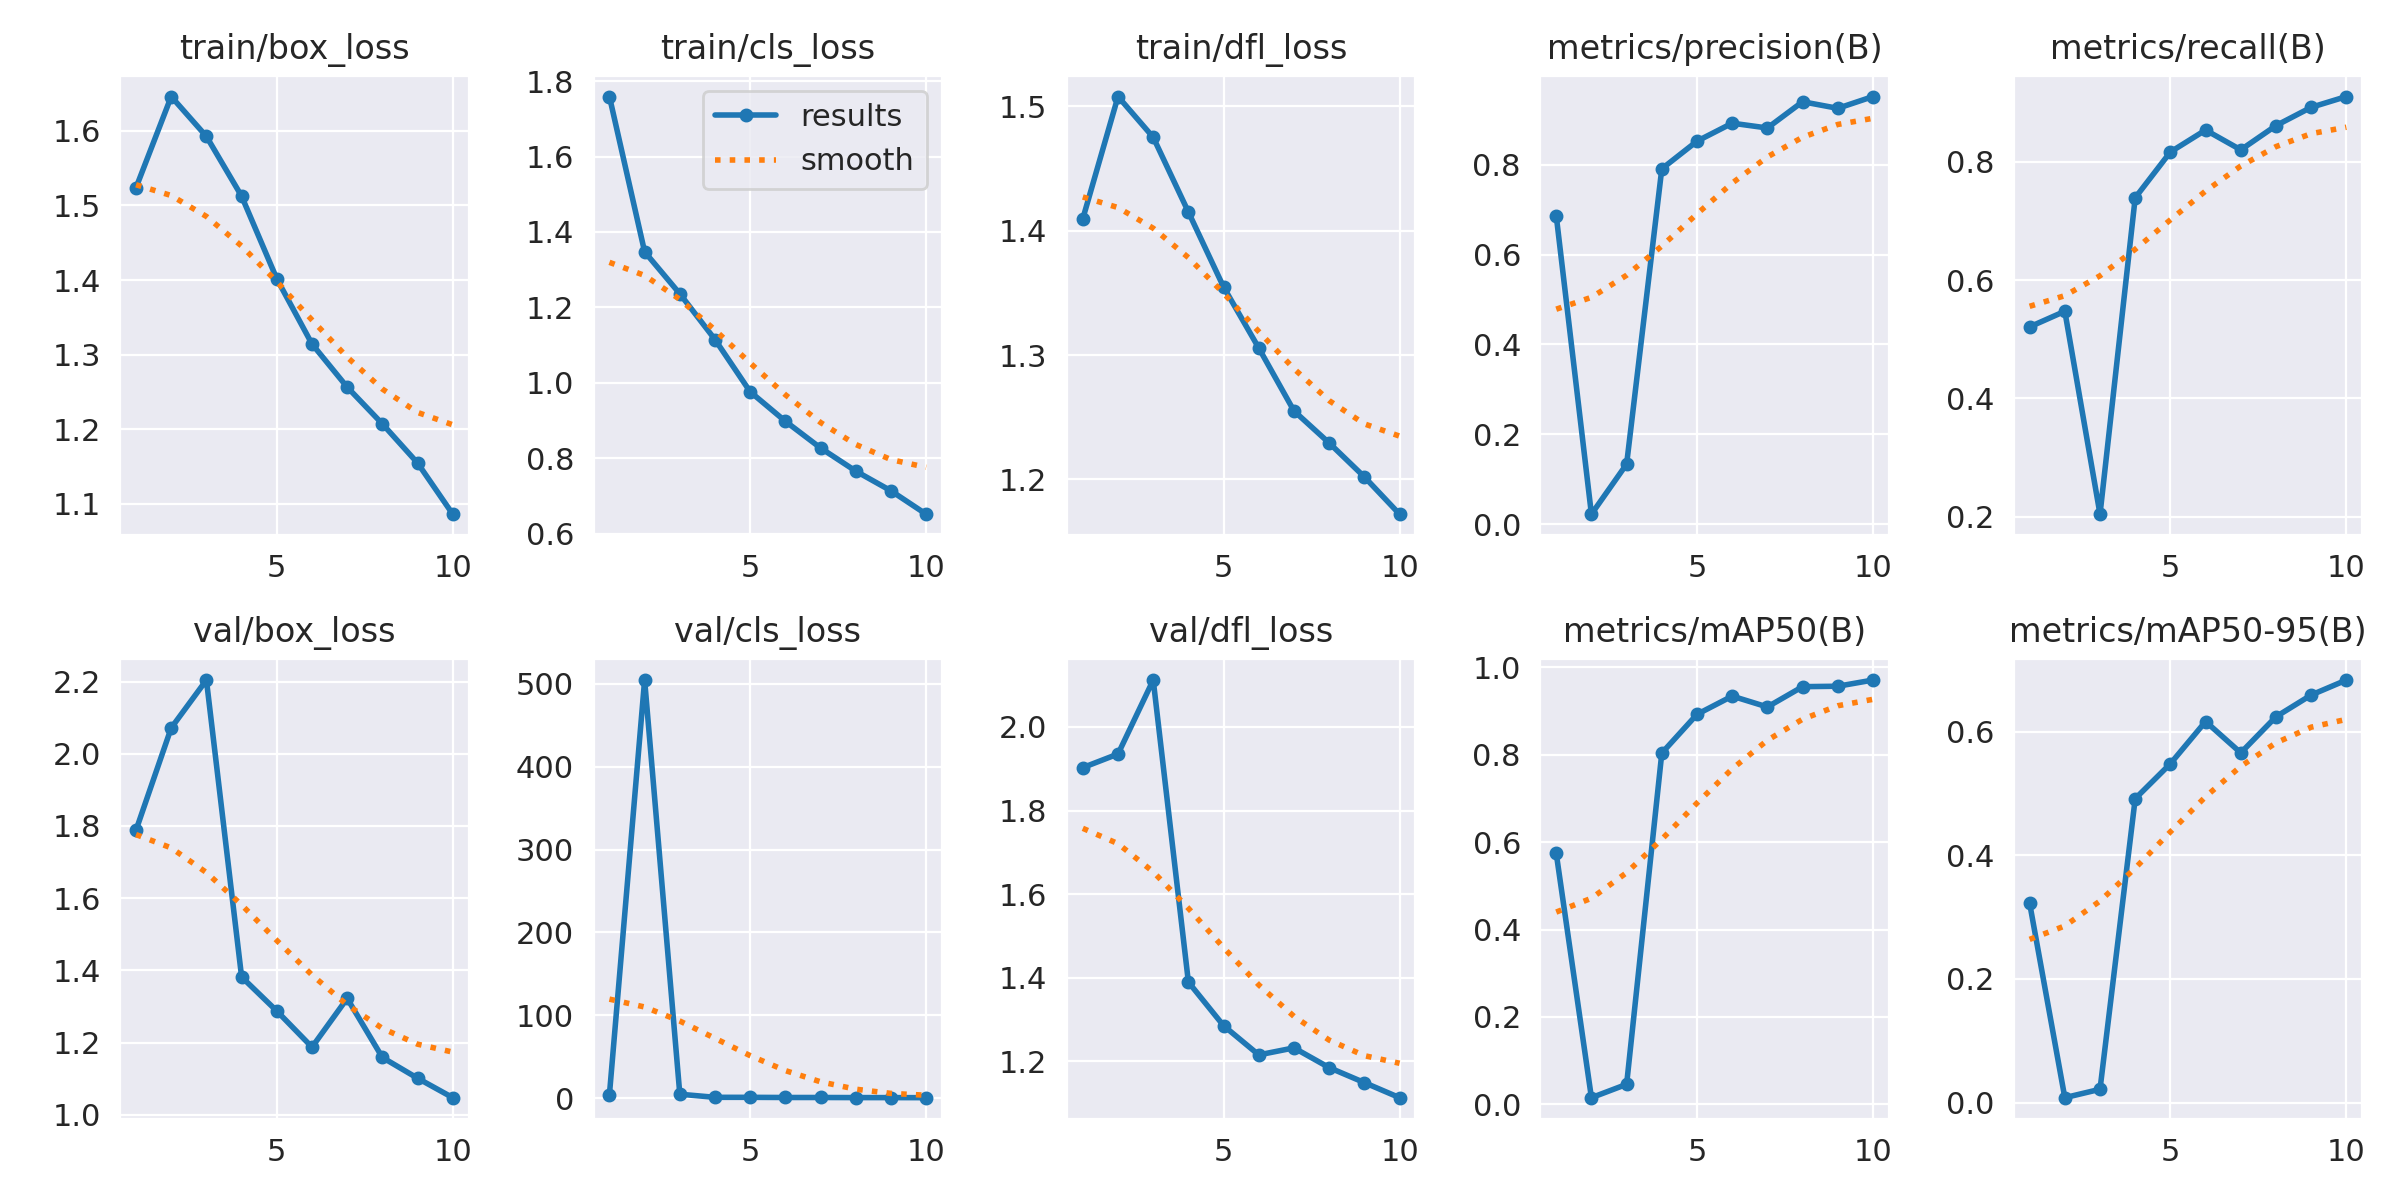

In [ ]:
Image('train_SAR_sdp12/results.png')

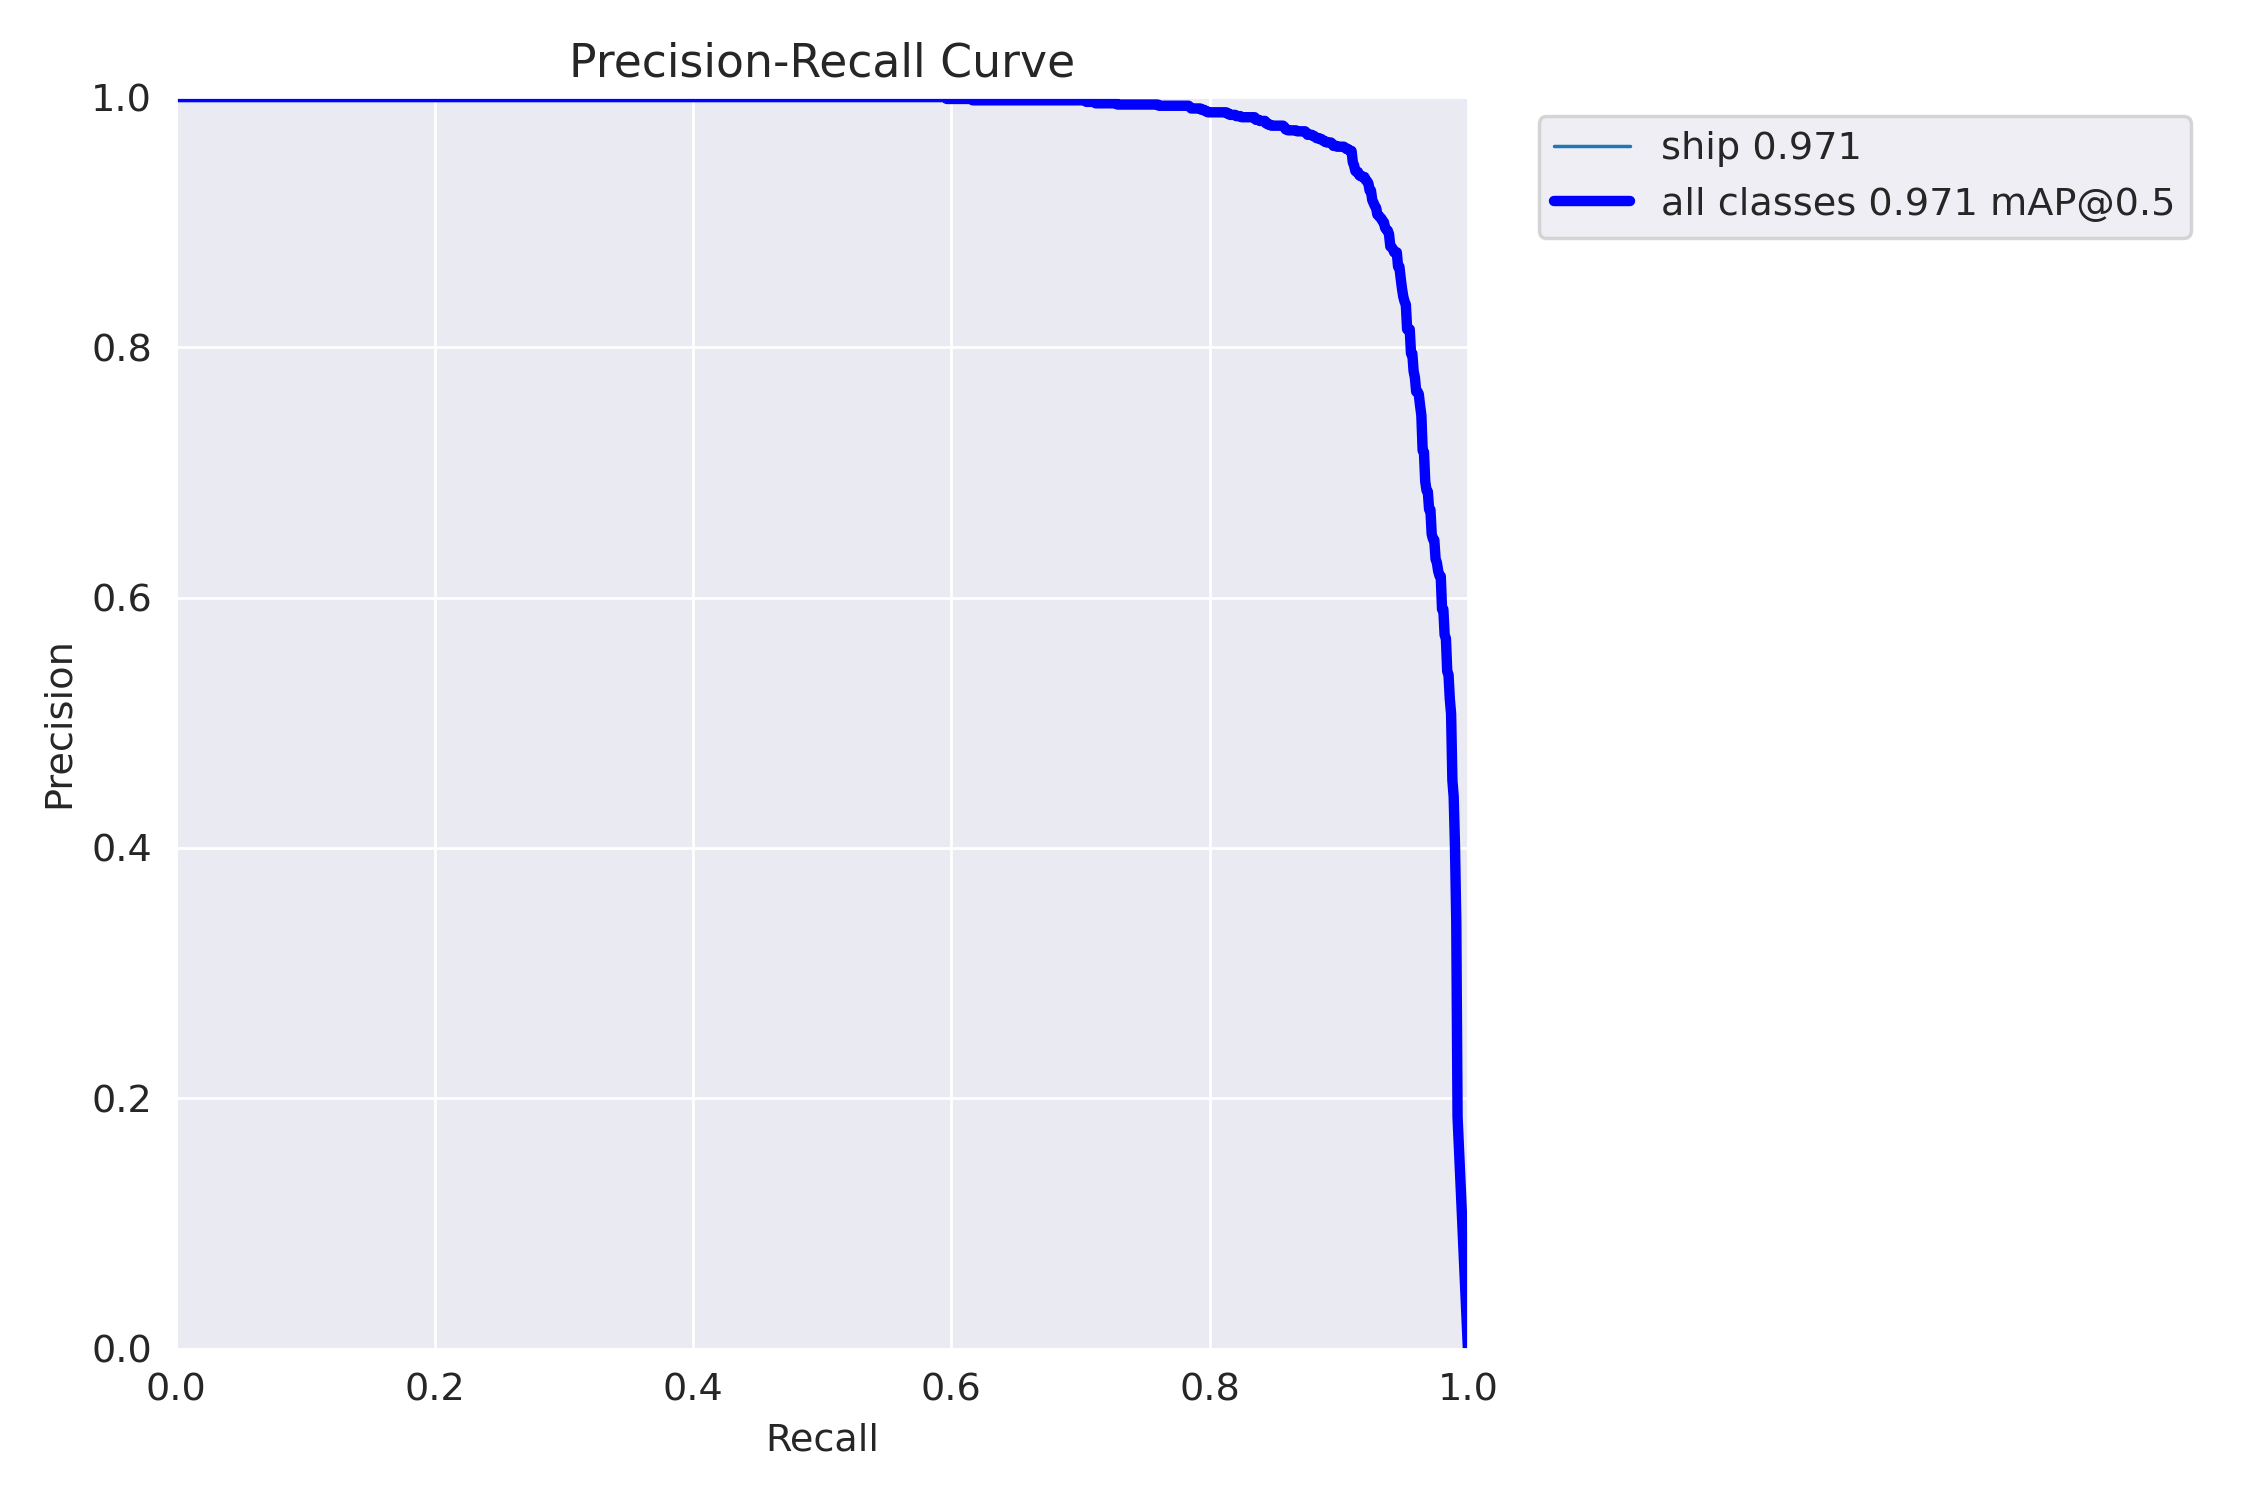

In [ ]:
Image('train_SAR_sdp12/PR_curve.png')

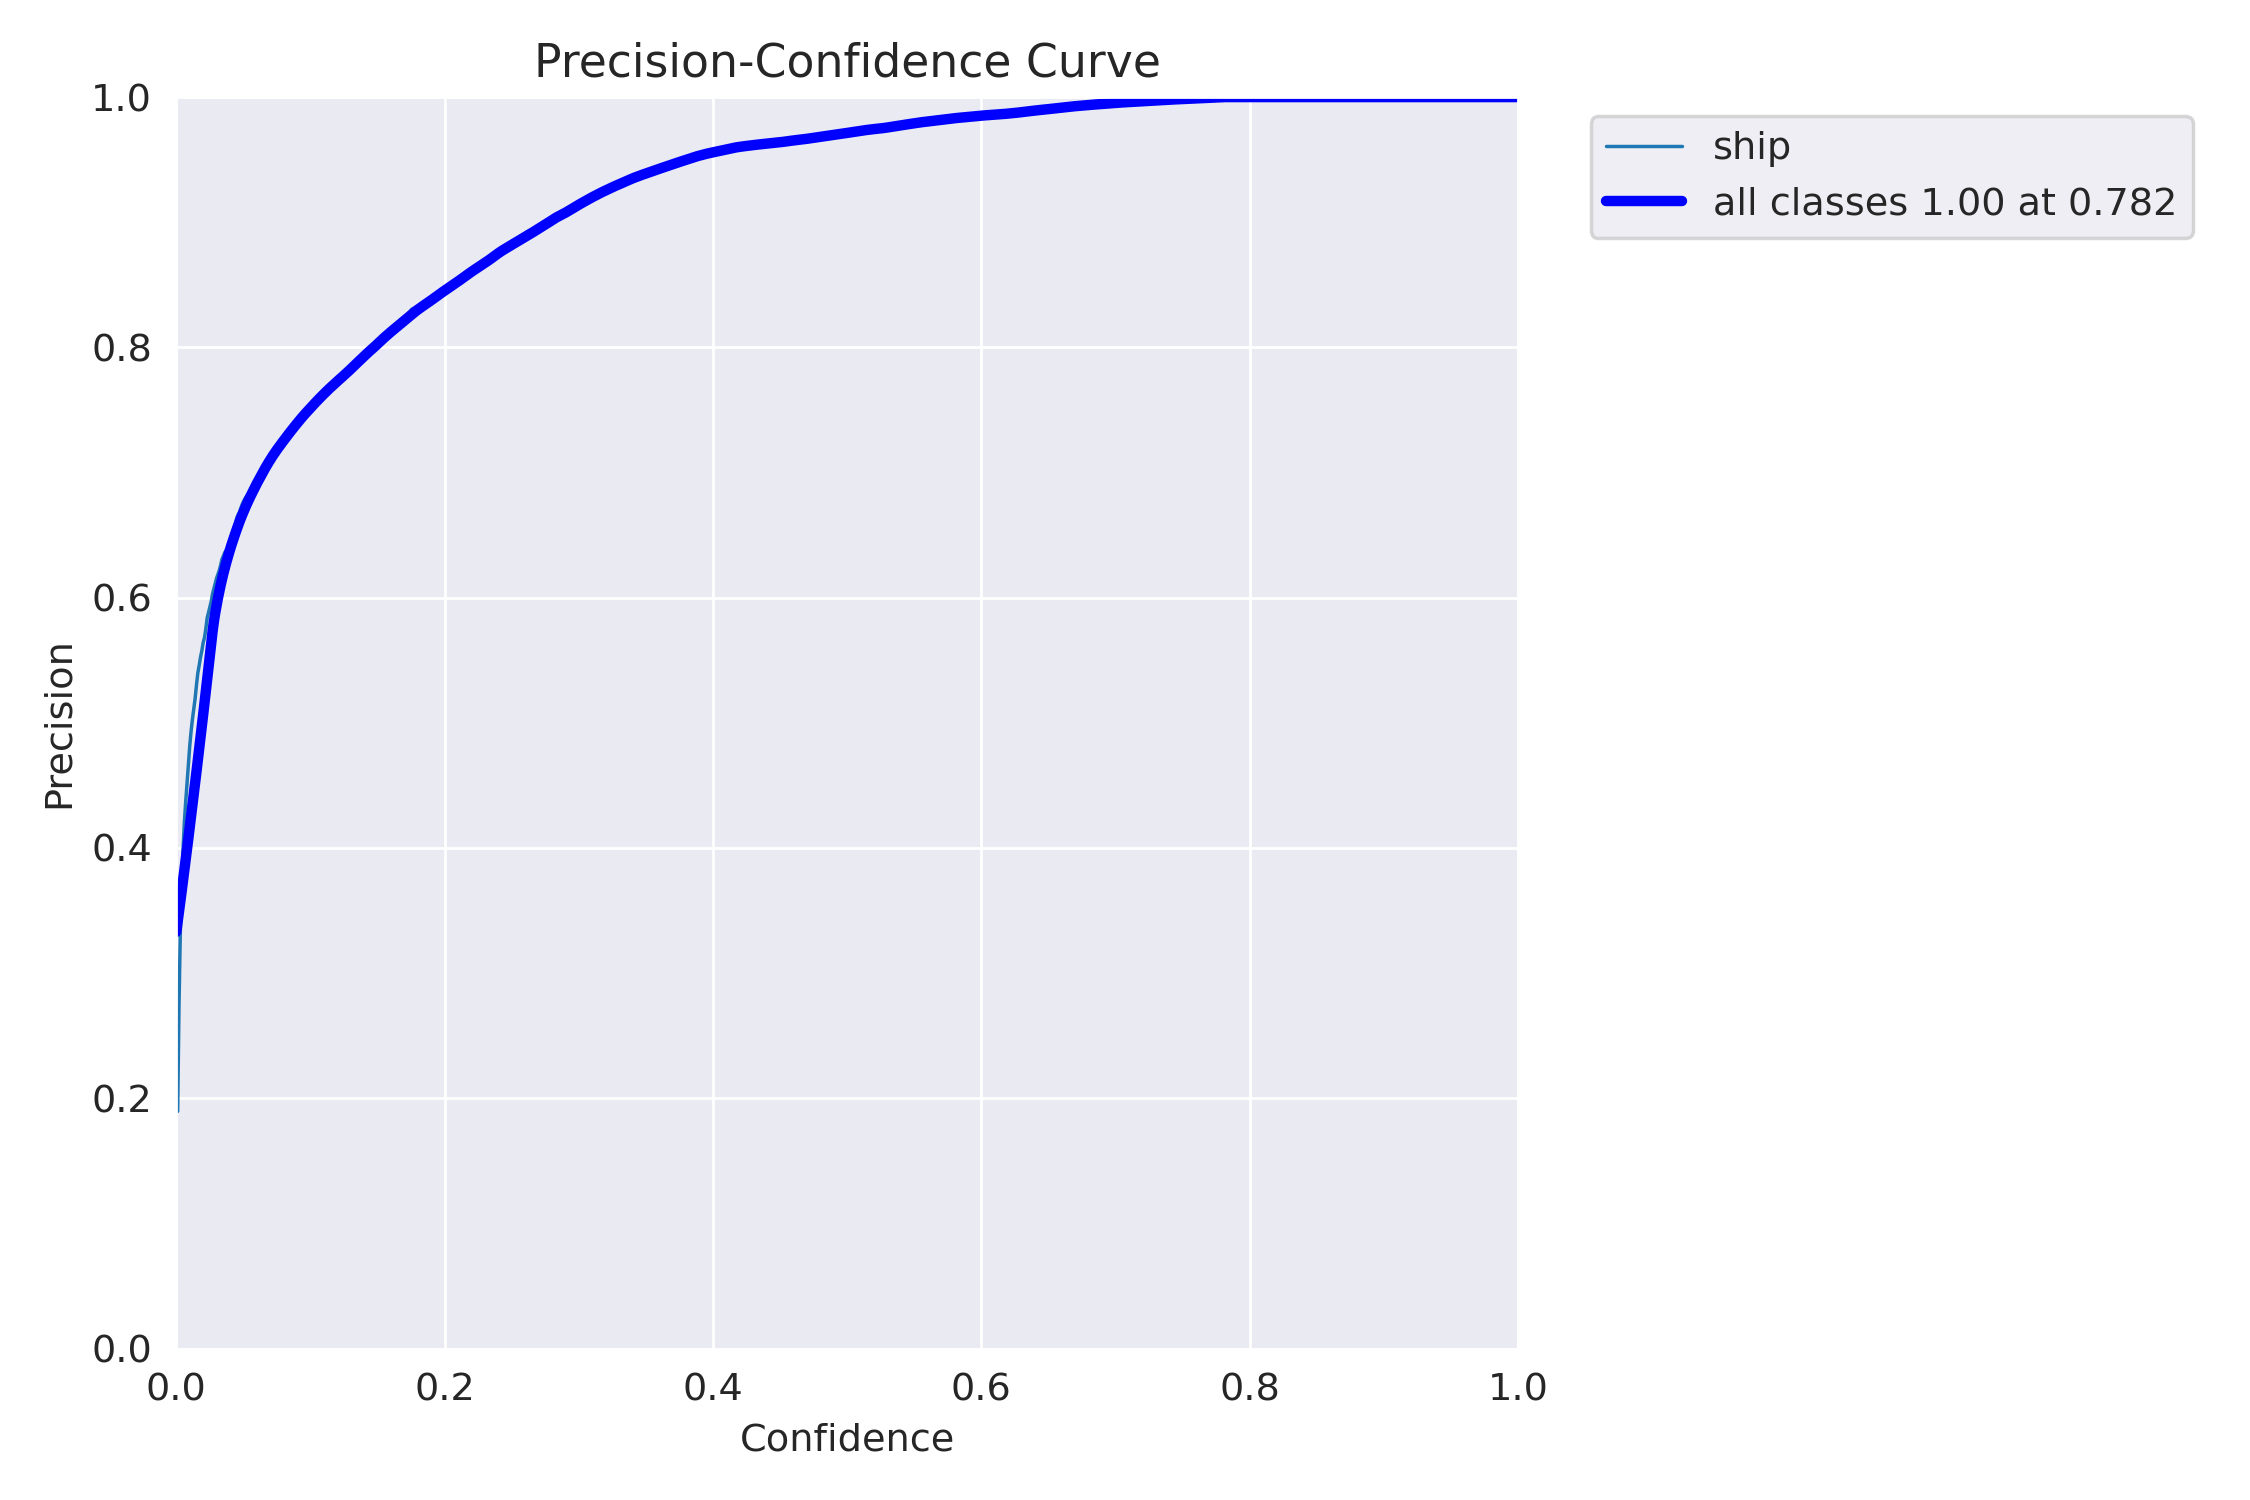

In [ ]:
Image('train_SAR_sdp12/P_curve.png')

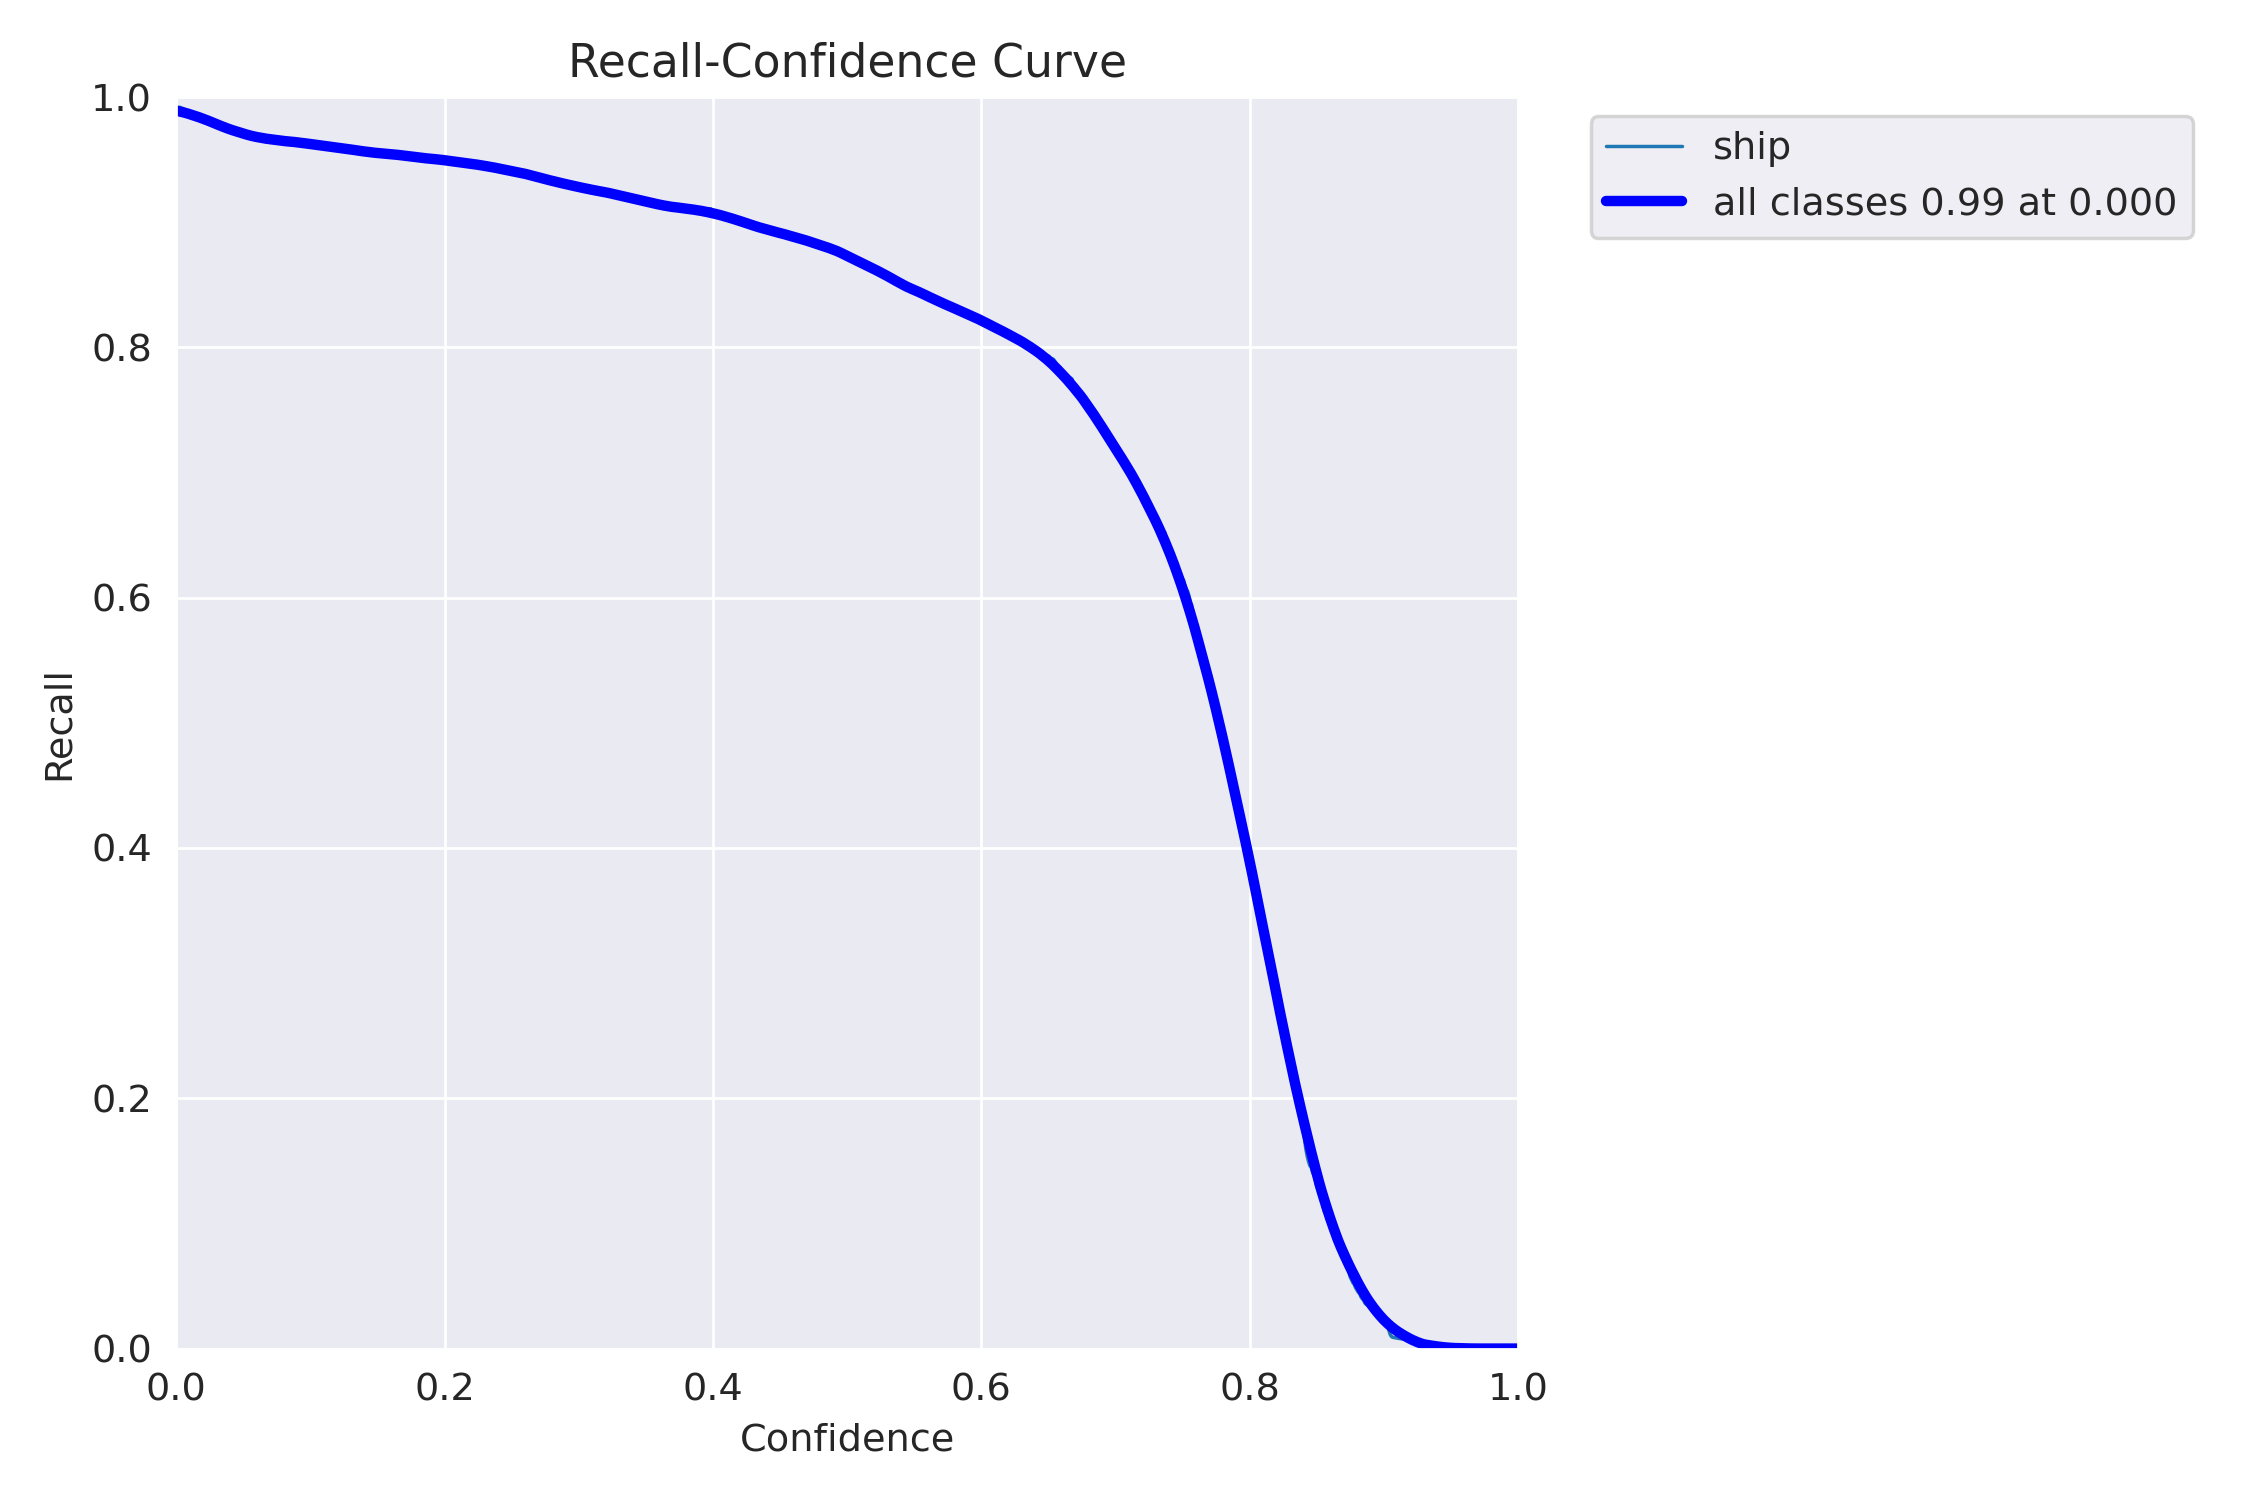

In [ ]:
Image('train_SAR_sdp12/R_curve.png')

#7. Prediction with test data

In [ ]:
model_test = YOLO(model="train_SAR_sdp12/weights/best.pt")
model_test

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): RepNCSPELAN4(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              

In [84]:
results_test = model_test.val(data=os.path.join(out_dir,'SAR_ship','data_sar_ship.yaml'),split="test")
results_test


Ultralytics 8.3.71 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (AMD EPYC 7B12)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/test/labels... 225 images, 0 backgrounds, 71 corrupt: 100%|██████████| 225/225 [00:39<00:00,  5.74it/s]

val: WARNING ⚠️ /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/test/images/000017.rf.9d56f1200660ae6d2df88befe9bfd783.jpg: ignoring corrupt image/label: Label class 11 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/test/images/000043_jpg.rf.c5bd53fe793bd31125d985ec02e53206.jpg: ignoring corrupt image/label: Label class 11 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/test/images/000059.rf.f517fd24ee85c0add98d4b07bdc1bbdb.jpg: ignoring corrupt image/label: Label class 24 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/test/images/000089_jpg.rf.a027326bd1c33c38

val: New cache created: /content/gdrive/MyDrive/Colab Notebooks/boat-detection-remote-sensing-deep-learning/data/SAR_ship/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:17<00:00,  7.73s/it]


                   all        154        154      0.955      0.955      0.983      0.739
Speed: 0.5ms preprocess, 489.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /usr/local/lib/python3.11/dist-packages/tests/tmp/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f32e2cb8bd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [88]:
results.results_dict

{'metrics/precision(B)': 0.9519926228063842,
 'metrics/recall(B)': 0.9107468123861566,
 'metrics/mAP50(B)': 0.9711025100352231,
 'metrics/mAP50-95(B)': 0.683745122831205,
 'fitness': 0.7124808615516068}

We can also try to predict on a test image.

In [ ]:
#results_eval = model.predict(source='https://ultralytics.com/images/bus.jpg', save=True)
#print(type(results_eval))
#print(len(results_eval)) #length 1 because we only passed one image
#type(results_eval[0]) #

- Links related to model evaluation:

https://medium.com/@islam.sadeka/object-detection-with-yolo-17a16d85f80f
https://medium.com/@Mert.A/how-to-use-yolov9-for-object-detection-93598ad88d7d
https://docs.ultralytics.com/modes/val/#usage-examples

#8.Conclusions

In this notebook, I explored the visual detection of dredge small rive boat using Sentinel 1, satellite imagery data. We showed how to download and process Sentinel 1 data for multiple dates (almost three years) using COGS and STAC framework.

The overall goal was also to show how to leverage Sentinel 1 data once procesed. We used Sentinel1 data in a visual way to inspect the detection and movements of boats across 7 days and multiple location near El Borach on the border between Brazil and Bolivia.

We cropped the data to create image chips that can be used in a Deep Learning model training. The next step consists in creating object boxes around the boat locations.



#7.References


Obregón, M.A., Rodrigues, G., Costa, M.J., et al. (2019). Validation of ESA Sentinel-2 L2A aerosol optical thickness and columnar water vapour during 2017-2018. Remote Sensing, 11(14), 1649. https://doi.org/10.3390/rs11141649

Schläpfer, D., Borel, C.C., Keller, J., et al. (1998). Atmospheric precorrected differential absorption technique to retrieve columnar water vapor. Remote Sensing of Environment, 65(3), 353-366. https://doi.org/10.1016/S0034-4257(98)00044-3.

Gascon F., Bouzinac C., Thépaut O., et al. (2017). Copernicus Sentinel-2A calibration and products validation status. Remote Sensing, 9(6), 584. https://doi.org/10.3390/rs9060584


In [ ]:
############################# END OF SCRIPT ###################################

https://space.elspina.tech/how-to-annotate-bounding-boxes-with-the-geospatial-data-3dbc7d503f61

https://www.youtube.com/watch?v=pTJT8kKi9SM
https://people.duke.edu/~ccc14/duke-hts-2018/cliburn/The_Unix_Shell_05___Shell_Scripts.html

https://medium.com/internet-of-technology/yolov9-1-channel-training-9f18eff2f4f8


Note on confidence score

In [ ]:
https://github.com/ultralytics/ultralytics/issues/4149


========
Your conceptual understanding of confidence in YOLO models, and specifically YOLOv8, is fundamentally correct. Indeed, YOLO models define two types of confidence: box confidence and class confidence.

Box confidence is a measure of how certain the model is that a bounding box contains an object of interest. It combines the objectness score (the model's certainty that the box contains an object at all) with the Intersection over Union (IoU) between the predicted bounding box and the ground truth.

Class confidence, on the other hand, is an expression of how certain the model is that the detected object belongs to a particular class. This calculation involves taking the conditional probability of the class given that an object has been detected (Pr(Class_i|Object)), multiplying that with the objectness score and the IoU.

The confidence score that YOLOv8 outputs is a combination of these two confidences, which enables it to balance between how certain it is that a box contains an object and how certain it is about which class this object belongs to.

As for your question regarding metric curves, you're correct that the confidence score is often used as the X-axis. These curves allow us to see how precision, recall, F1 score, etc., change as we adjust the confidence threshold.

-------------------------


You are absolutely correct. During prediction on new unlabeled data, the Intersection over Union (IoU) with ground truth cannot be calculated as there is no ground truth available. In this case, the confidence score essentially becomes the product of the box confidence and the class confidence.

The box confidence represents how certain the model is that it has correctly placed a bounding box around an object, while the class confidence signifies the model's estimation of the object belonging to a specific class.

So, to your point, without a labeled ground truth available, these two confidences become the crucial factors determining the overall confidence score of the detection.

Thanks for your excellent question, and do reach out if you have any further questions or aspects you'd like to discuss.